In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans, DBSCAN

In [2]:
datos_integrantes =pd.DataFrame({"Nombre":["Emiliano Pedro","Odin Orlando","Juan Pablo"],"Apellido":["Gonzalez Lebrero","Nappe Schnalzer","Degrossi"],"LU":["562/23","635/23","624/23"],"Email":["emilebrero@gmail.com","odin.nappe@gmail.com","juampidegrossi@gmail.com"]})
datos_integrantes = datos_integrantes.set_index("LU")
datos_integrantes

Nombre          Apellido                     Email
LU                                                                
562/23  Emiliano Pedro  Gonzalez Lebrero      emilebrero@gmail.com
635/23    Odin Orlando   Nappe Schnalzer      odin.nappe@gmail.com
624/23      Juan Pablo          Degrossi  juampidegrossi@gmail.com

# PARTE 1 (Preprocesamiento)

Lo primero que hacemos que cargar los datos con los que vamos a trabajar.

In [5]:
estadisticas_20_21 = pd.read_csv("FBRef2020-21.csv")
estadisticas_20_21.head()

Player  Nation Pos           Squad                Comp   Age  \
0  Patrick van Aanholt  nl NED  DF  Crystal Palace  eng Premier League  29.0   
1     Yunis Abdelhamid  ma MAR  DF           Reims          fr Ligue 1  32.0   
2      Pape Abou Cisse  sn SEN  DF   Saint-Étienne          fr Ligue 1  24.0   
3        David Abraham  ar ARG  DF  Eint Frankfurt       de Bundesliga  34.0   
4     Francesco Acerbi  it ITA  DF           Lazio          it Serie A  32.0   

     Born  MP  Starts   Min  ...  PrgDistCarry/90  ProgCarry/90  \
0  1990.0  22      20  1777  ...             96.8          5.79   
1  1987.0  33      33  2889  ...            130.5          1.81   
2  1995.0  14      14  1260  ...            117.9          1.14   
3  1986.0  14      14  1222  ...             92.7          3.24   
4  1988.0  32      32  2813  ...            166.3          3.71   

   CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0               1.52             0.46           0.66             0.81   
1               0.25             0.03           0.25             0.47   
2               0.07             0.00           0.14             0.07   
3               0.66             0.00           0.22             0.00   
4               1.02             0.03           0.45             0.26   

   PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0           42.3               39.3      92.8                 2.34  
1           43.8               42.5      97.0                 0.22  
2           33.7               32.9      97.7                 0.00  
3           34.8               33.4      96.0                 0.59  
4           50.9               49.5      97.3                 0.70  

[5 rows x 128 columns]

Ahora vamos a realizar diferentes operaciones para poder obtener mejores resultados en los modelos que vamos a crear más adelante.   
Cosas que vamos a hacer:   
1. Eliminar jugadores con menos de 500min jugados.
2. Eliminar columnas con muchos datos faltantes (NaN).  
3. De las columnas que estan despues de "Ast/90" (comun 11) me quedo solo con las numericas.

In [6]:
estadisticas_20_21 = estadisticas_20_21[estadisticas_20_21["Min"]>=500] #Eliminamos jugadores con menos de 500min jugados

In [7]:
with pd.option_context('display.max_rows', None): #Aca miramos cuantos datos faltantes hay por columnas o por lo menos lo que nos permite ver.
    print(estadisticas_20_21.isna().sum())

Player                   0
Nation                   0
Pos                      0
Squad                    0
Comp                     0
Age                      0
Born                     0
MP                       0
Starts                   0
Min                      0
90s                      0
Ast/90                   0
npG/90                   0
npG+A/90                 0
xA/90                    2
npxG/90                  2
npxG+xA/90               2
Shots/90                 0
SoTs/90                  0
SoT%                   140
Gls/Shot               140
Gls/SoT                298
AvgShotDist            142
FKSht/90                 2
npxG/Shot              142
np:G-xG                  2
PassCmp/90               2
PassAtt/90               2
PassCmp%                 2
TotDistPass/90           2
PrgDistPass/90           2
ShortCmp/90              2
ShortAtt/90              2
ShortCmp%                2
MedCmp/90                2
MedAtt/90                2
MedCmp%                  2
L

In [8]:
nan_cols = estadisticas_20_21.isna().sum() > 100  # Vector booleano (la columna tiene mas de 100 datos faltantes, entonces true)
keep = nan_cols.index[~(nan_cols)] # Lista con los nombres de las columnas para dejar
estadisticas_20_21 = estadisticas_20_21[keep] # Seleccionamos solo las columnas en keep

In [9]:
estadisticas_20_21.head() # Notamos la disminucion de columnas, 6 exactamente.

Player  Nation Pos           Squad                Comp   Age  \
0  Patrick van Aanholt  nl NED  DF  Crystal Palace  eng Premier League  29.0   
1     Yunis Abdelhamid  ma MAR  DF           Reims          fr Ligue 1  32.0   
2      Pape Abou Cisse  sn SEN  DF   Saint-Étienne          fr Ligue 1  24.0   
3        David Abraham  ar ARG  DF  Eint Frankfurt       de Bundesliga  34.0   
4     Francesco Acerbi  it ITA  DF           Lazio          it Serie A  32.0   

     Born  MP  Starts   Min  ...  PrgDistCarry/90  ProgCarry/90  \
0  1990.0  22      20  1777  ...             96.8          5.79   
1  1987.0  33      33  2889  ...            130.5          1.81   
2  1995.0  14      14  1260  ...            117.9          1.14   
3  1986.0  14      14  1222  ...             92.7          3.24   
4  1988.0  32      32  2813  ...            166.3          3.71   

   CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0               1.52             0.46           0.66             0.81   
1               0.25             0.03           0.25             0.47   
2               0.07             0.00           0.14             0.07   
3               0.66             0.00           0.22             0.00   
4               1.02             0.03           0.45             0.26   

   PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0           42.3               39.3      92.8                 2.34  
1           43.8               42.5      97.0                 0.22  
2           33.7               32.9      97.7                 0.00  
3           34.8               33.4      96.0                 0.59  
4           50.9               49.5      97.3                 0.70  

[5 rows x 122 columns]

In [10]:
estadisticas_20_21 = estadisticas_20_21.dropna(axis=0) #Ahora eliminamos las filas con datos faltantes (Tambien se podria cambiar los NaN a 0 si es que todos los datos faltantes estan en columnas numericas).

In [11]:
estadisticas_20_21 = estadisticas_20_21.reset_index(drop=True) # Reseteamos los indices 

In [12]:
estadisticas_20_21.info() # Vemos que solo hay 10 columnas que no son numericas 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Columns: 122 entries, Player to ProgPassReceived/90
dtypes: float64(109), int64(3), object(10)
memory usage: 1.8+ MB


In [13]:
columnas = estadisticas_20_21.columns # Me armo un nuevo dataframe en el que saco las columnas anteriores a "Ast/90"
pasar = False
data_num = pd.DataFrame()
for nombre in columnas:
    if nombre=="Ast/90":
        pasar = True
    if pasar:
        data_num[nombre] = estadisticas_20_21[[nombre]]


C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\3949000862.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_num[nombre] = estadisticas_20_21[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\3949000862.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_num[nombre] = estadisticas_20_21[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\3949000862.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [14]:
data_num.head() #Funciono

Ast/90  npG/90  npG+A/90  xA/90  npxG/90  npxG+xA/90  Shots/90  SoTs/90  \
0    0.05    0.00      0.05   0.04     0.06        0.10      0.91     0.30   
1    0.00    0.09      0.09   0.01     0.05        0.06      0.47     0.16   
2    0.00    0.00      0.00   0.00     0.08        0.09      0.93     0.21   
3    0.00    0.07      0.07   0.03     0.05        0.08      0.66     0.15   
4    0.03    0.00      0.03   0.03     0.03        0.06      0.26     0.00   

   FKSht/90  np:G-xG  ...  PrgDistCarry/90  ProgCarry/90  CarryIntoThird/90  \
0      0.15    -0.06  ...             96.8          5.79               1.52   
1      0.00     0.04  ...            130.5          1.81               0.25   
2      0.00    -0.09  ...            117.9          1.14               0.07   
3      0.00     0.02  ...             92.7          3.24               0.66   
4      0.00    -0.03  ...            166.3          3.71               1.02   

   CarryIntoBox/90  Miscontrol/90  Dispossessed/90  PassTarget/90  \
0             0.46           0.66             0.81           42.3   
1             0.03           0.25             0.47           43.8   
2             0.00           0.14             0.07           33.7   
3             0.00           0.22             0.00           34.8   
4             0.03           0.45             0.26           50.9   

   PassesReceived/90  PassRec%  ProgPassReceived/90  
0               39.3      92.8                 2.34  
1               42.5      97.0                 0.22  
2               32.9      97.7                 0.00  
3               33.4      96.0                 0.59  
4               49.5      97.3                 0.70  

[5 rows x 111 columns]

In [15]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Columns: 111 entries, Ast/90 to ProgPassReceived/90
dtypes: float64(106), object(5)
memory usage: 1.6+ MB


In [16]:
data_num = data_num.select_dtypes(exclude=["object"]) # eliminamos todas las columnas de tipo objeto

In [17]:
data_num.info() #Pefecto, eliminamos las columnas de tipo objeto.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Columns: 106 entries, Ast/90 to ProgPassReceived/90
dtypes: float64(106)
memory usage: 1.5 MB


# PARTE 2 (Clustering)

## Ejercicio 6

### Apartado (a)

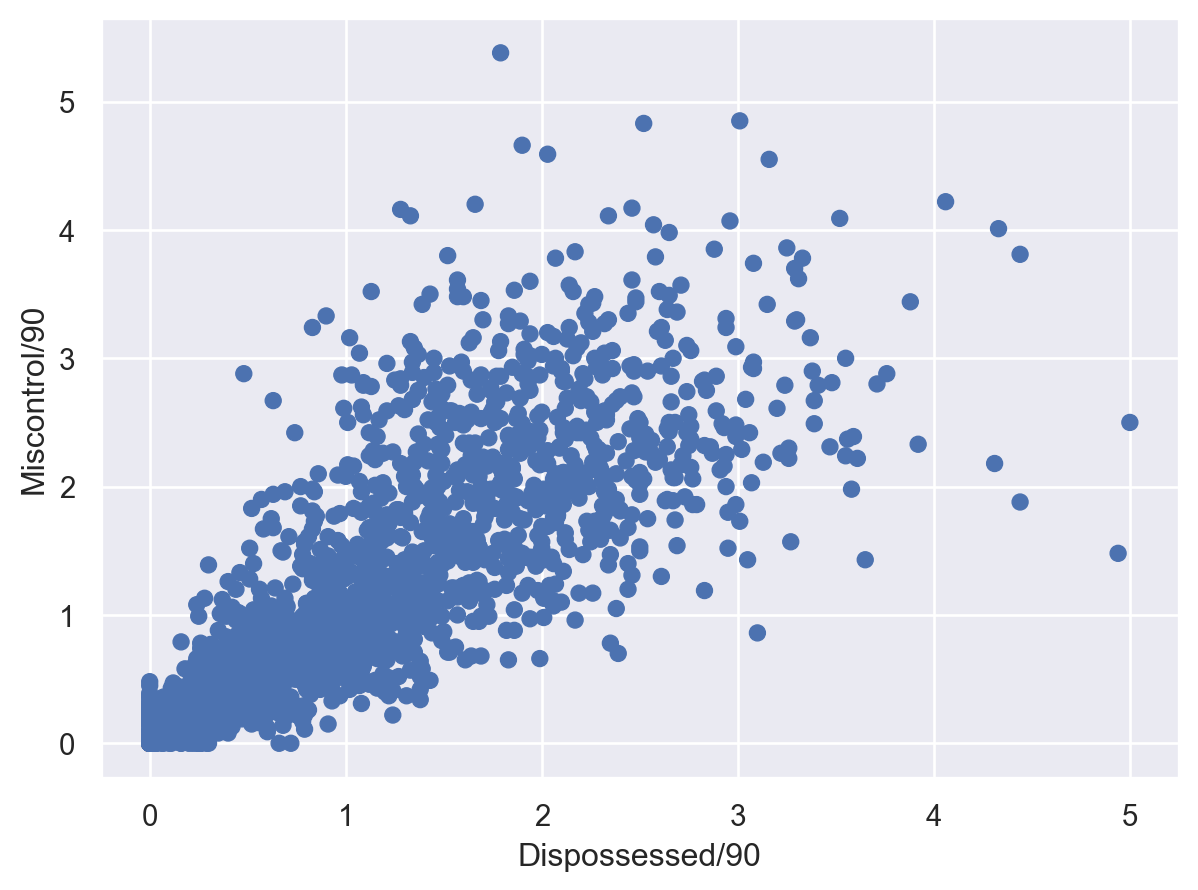

In [18]:
(
    so.Plot(estadisticas_20_21,y="Miscontrol/90",x="Dispossessed/90").add(so.Dot())
)

Decidimos utilizar estas variables ya que consideramos que hay una relacion directa de la perdida de control y las veces que un jugador pierde la pelota. A pesar de que no se ve ningun cluster de manera directa creemos que hay una relación que no podemos ver en el grafico.

Despues de hacer muchas pruebas de diferentes conjuntos de variables a utilizar para hacer PCA no llegamos a armar ningun cluster visible por lo que optamos por utilizarlas todas. No consideramos que sea lo más optimo pero debido a nuestra falta de conocimiento del deporte y el poco tiempo con el que estamos contando en este momento vamos a realizarlo de dicha manera.

### Apartado (b)

In [19]:
data_pca = data_num.copy() #Hacemos una copia para manteren los datos originales sin modificaciones

In [20]:
X_star = StandardScaler().set_output(transform="pandas").fit_transform(data_pca) #Escalamos los datos para hacer PCA

In [21]:
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(X_star)
data_pca = pd.DataFrame(data=componentes_principales, columns=['PC1', 'PC2'])

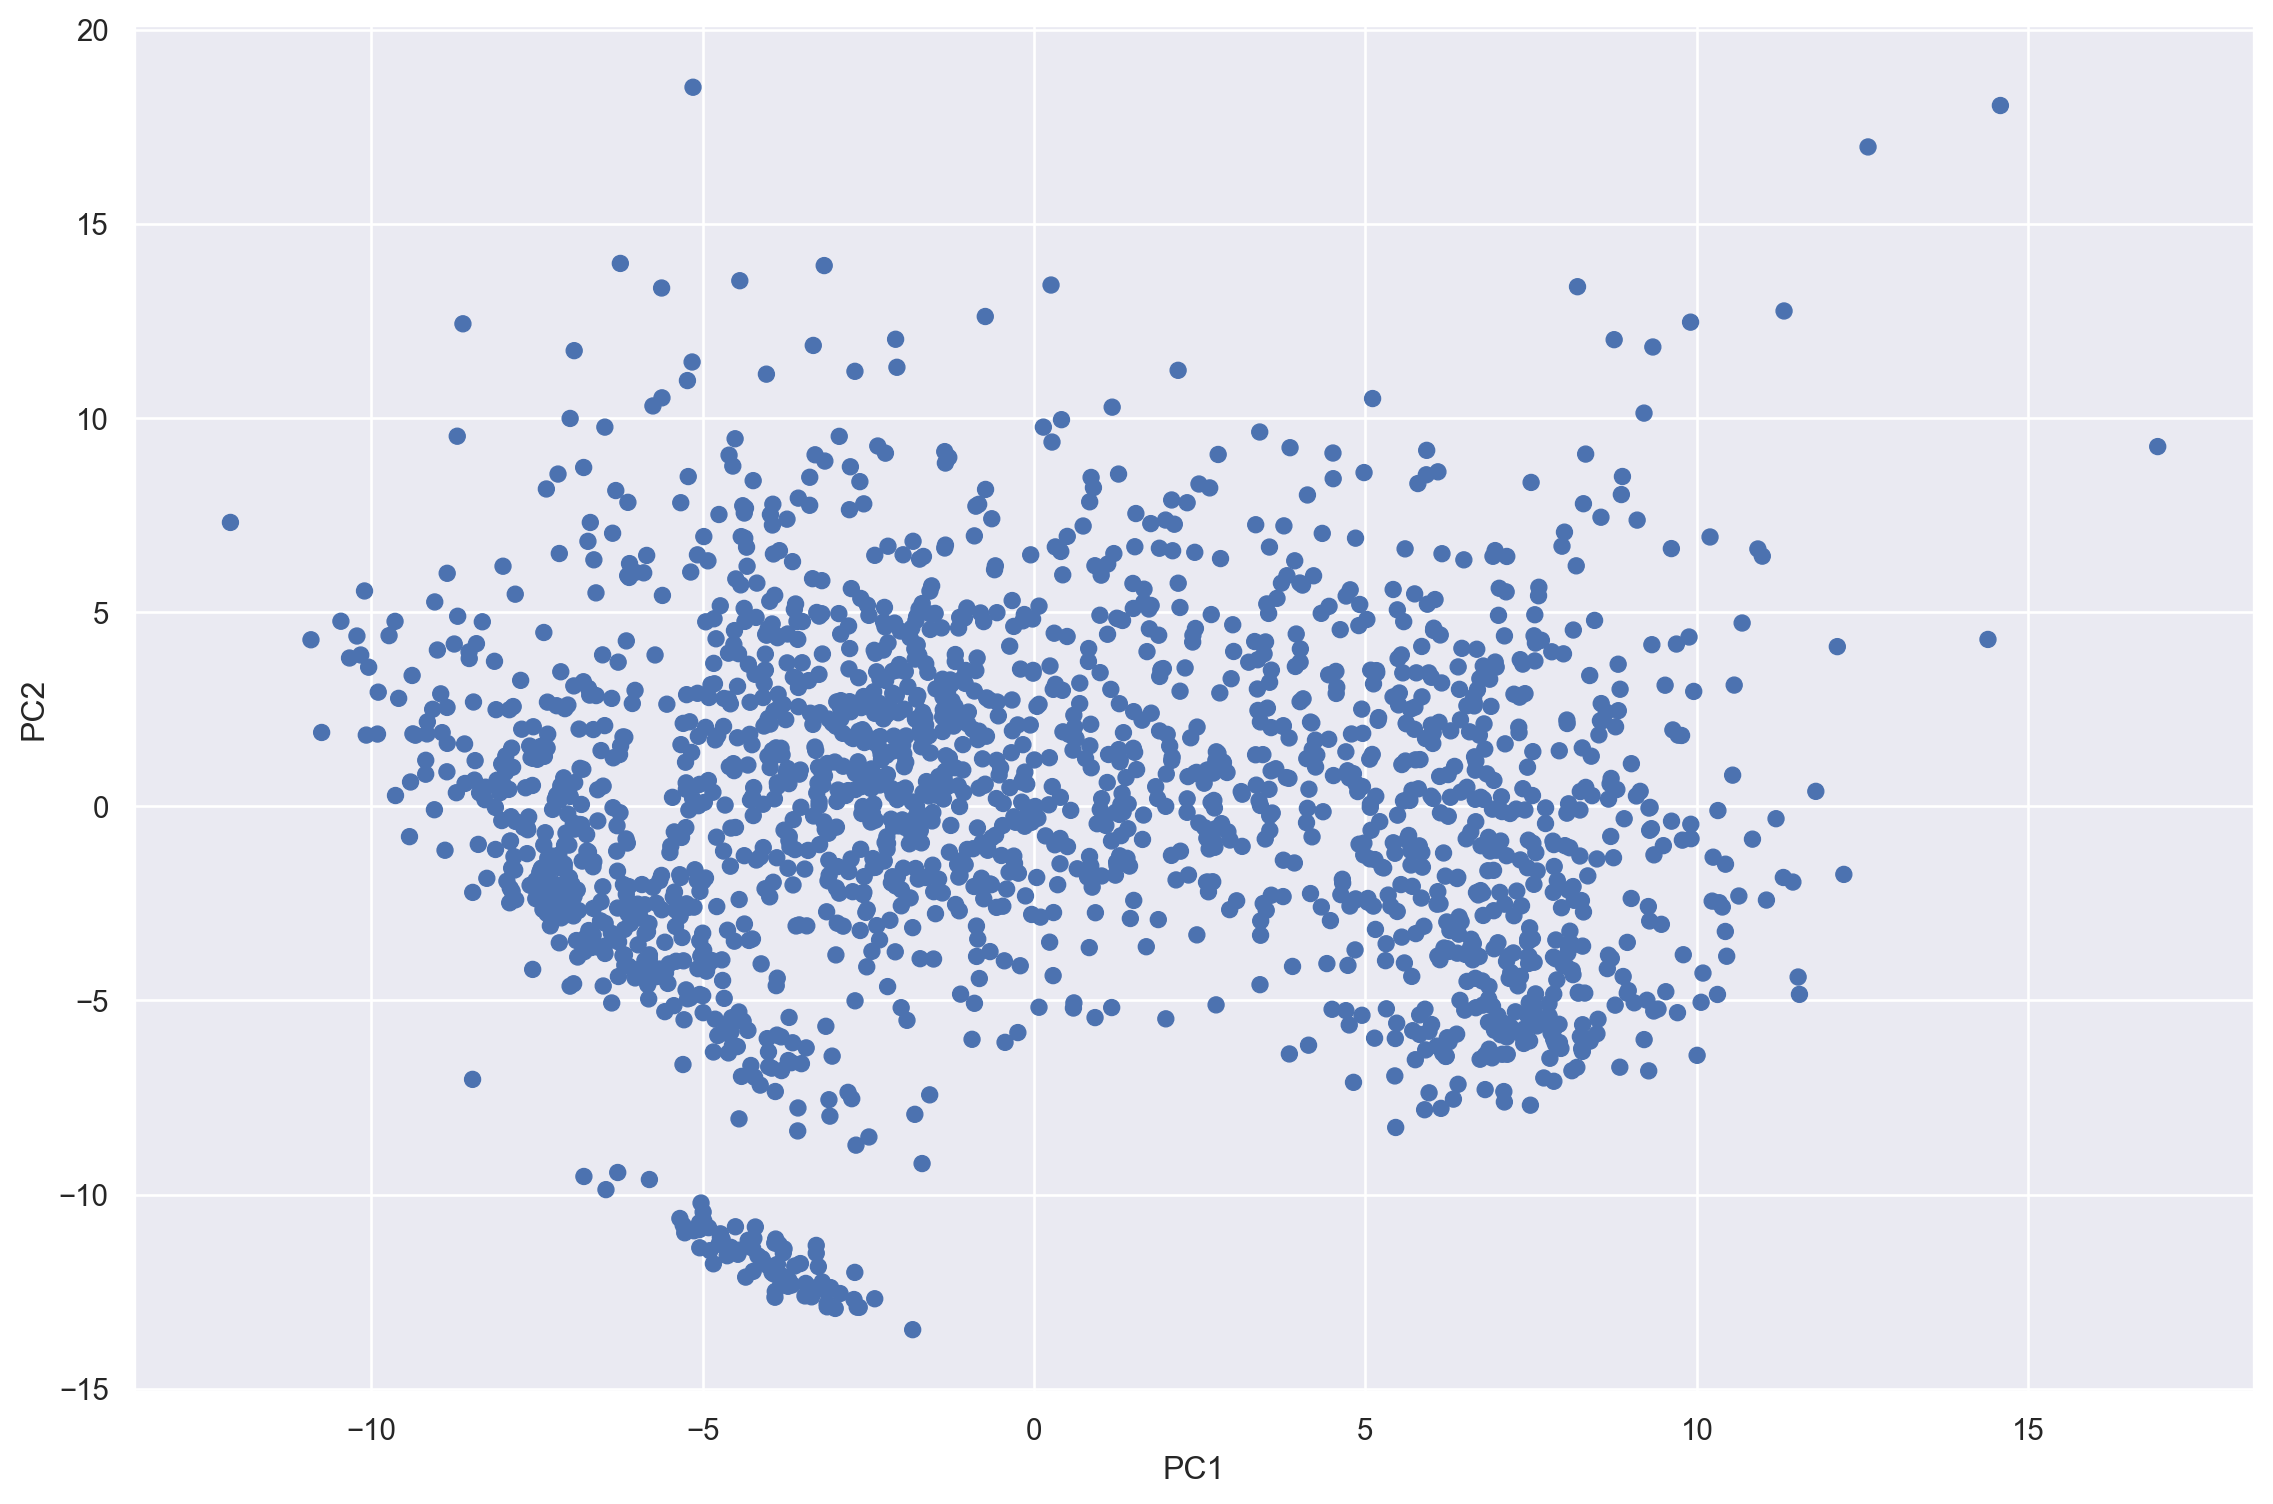

In [22]:
(
    so.Plot(x = data_pca["PC1"], y = data_pca["PC2"])
    .add(so.Dot())
    .layout(size=(12,8))
)

En este grafico podemos llegar a distinguir 4 grupos a pesar de que estan muy unidos y dispersos. Creemos que estos grupos se deben a las posiciones que ocupan los jugadores.  
Vamos a averiguarlo...

Para hacerlo vamos a quedarnos con una posición para cada jugador y luego los vamos a generarnos una variable categorica más general segun la ubicación en el campo de juego.

In [23]:
estadisticas = estadisticas_20_21.reset_index(drop=True)
Pos=[] # Creamos la columna Pos_fil que nos pide la consigna A
for i in range(len(estadisticas)):
  if len(estadisticas.iloc[i]['Pos'])>2:
    Pos.append(estadisticas.iloc[i]['Pos'][:2:])
  else:
    Pos.append(estadisticas.iloc[i]['Pos'])
Pos=pd.DataFrame(Pos)

In [24]:
data_pca["pos"]=Pos
data_pca

PC1       PC2 pos
0    -2.914489  2.251300  DF
1    -6.818411 -1.413789  DF
2    -6.474281 -3.792534  DF
3    -5.082957 -1.910314  DF
4    -7.441709  1.540059  DF
...        ...       ...  ..
1897  1.988080 -5.476240  MF
1898  7.132944  6.430474  MF
1899  6.800949  1.470304  MF
1900  6.848639 -0.878121  MF
1901  2.459634  2.036907  MF

[1902 rows x 3 columns]

In [25]:
# Me armo listas donde guardo a que tipo de juego pertenece cada posición
arquero = ["GK"]
defensa = ["DF","CB","FB","LB","RB"]
medio = ["MF","DM","CM","LM","RM","WM","AM",]
delanteros = ["FW","LW","RW"]

In [26]:
pos_1 = []
for x in data_pca["pos"]:
    if x in arquero:
        pos_1.append("arquero")
    elif x in defensa:
        pos_1.append("defensa")
    elif x in medio:
        pos_1.append("medio")
    elif x in delanteros:
        pos_1.append("delantero")

In [27]:
data_pca["pos_generica"]=pd.DataFrame(pos_1)

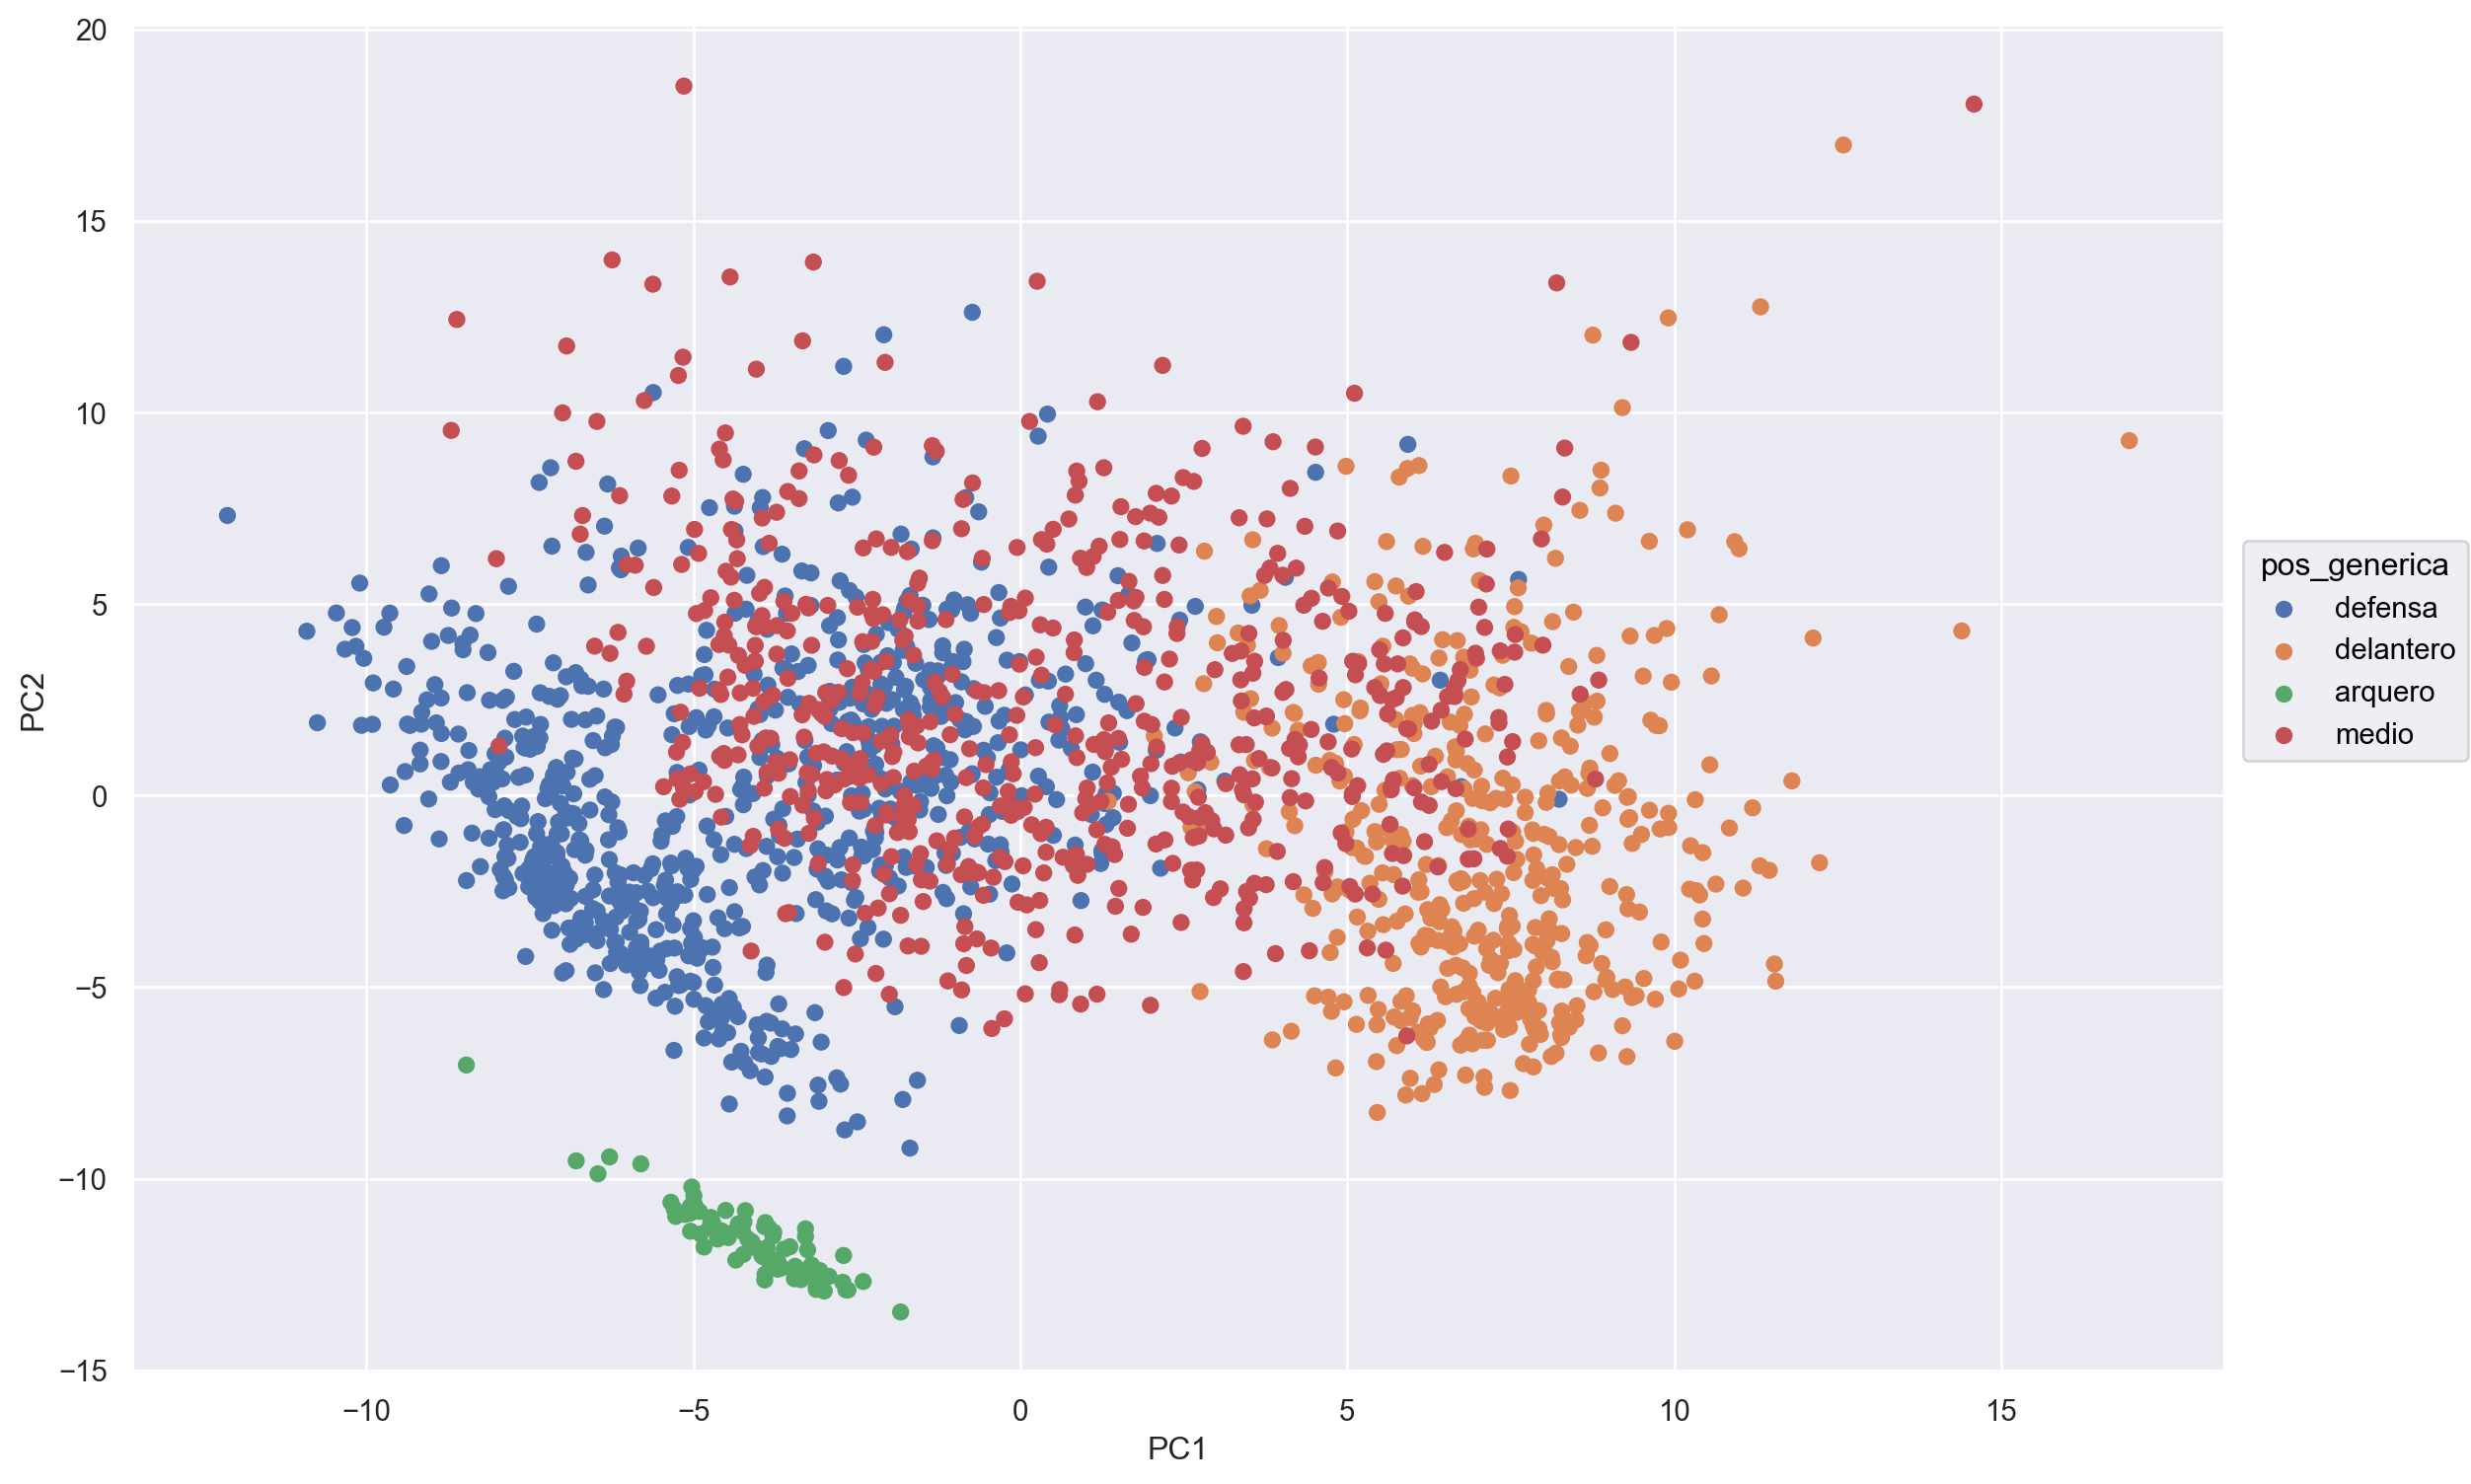

In [28]:
(
    so.Plot(x = data_pca["PC1"], y = data_pca["PC2"], color=data_pca["pos_generica"])
    .add(so.Dot())
    .layout(size=(12,8))
)

Nos quedo hermoso. Se pueden distinguir claramente los 4 clusters a pesar de que el grupo de mediocampistas esta bastante disperso y superpuesto con los grupos de defensores y delanteros. Creemos que esto se puede dar debido a que los jugadores que estan en el medio pasan constantemente de ataque a defensa y de defensa a ataque durante todo el partido, sumado a que hay mediocampistas más defensivos y otros más ofensivos. 

Ahora vamos a ver que pasa con un agrupamiento mediante k-medias. De base creemos que no se va a ver lo mismo que antes ya que un grupo esta superpuesto con otro y eso puede llevar a resultados erroneos.

### Apartado (c)

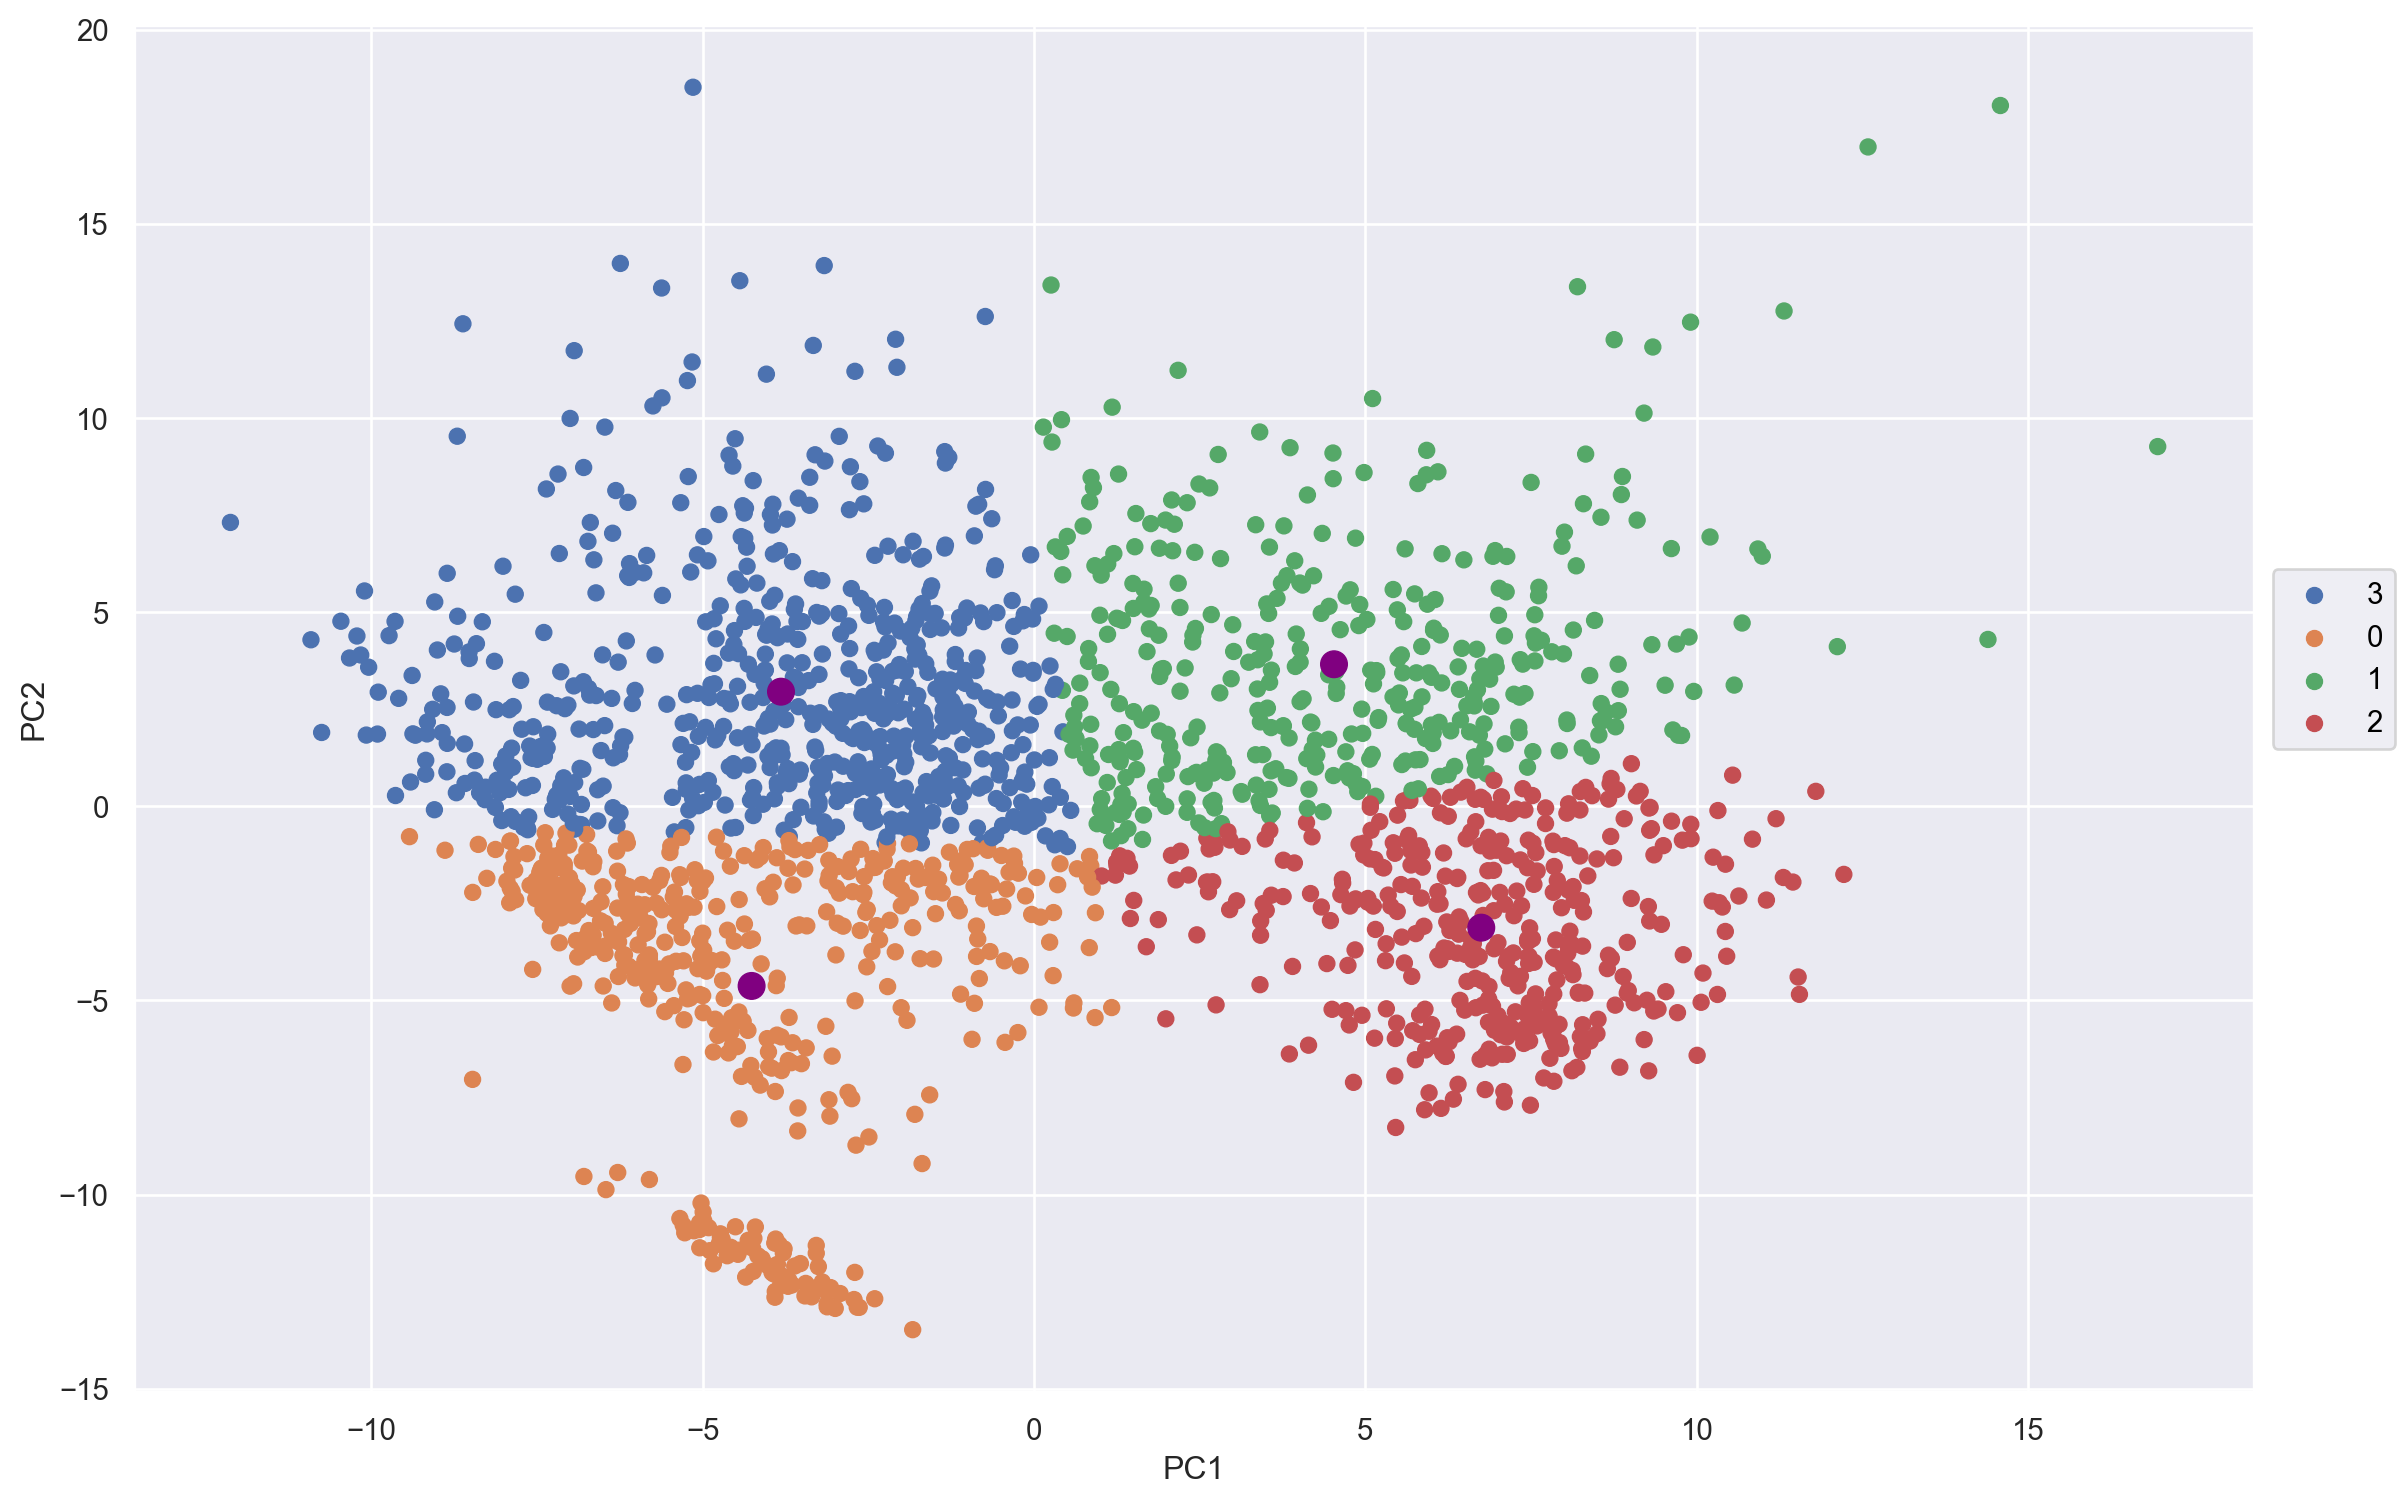

In [29]:
kmeans = KMeans(n_clusters=4)
cluster = kmeans.fit_predict(data_pca[["PC1","PC2"]])
(
    so.Plot()
    .add(so.Dot(),data=data_pca[["PC1","PC2"]],x="PC1",y="PC2",color=cluster.astype("str"))
    .layout(size=(12,8))
    .add(so.Dot(color = "purple", pointsize = 10), x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1])
)

Nos parece que nos dio un resultado mejor a lo esperado, aunque el problema que planteamos antes se vio reflejado en el grafico. Los diferentes grupos se vieron alterados principalmente a la superposición de los medicoampistas con los defensores y delanteros.

Para verificar eso, como plus al ejercicio, vamos a volver a realizar el k-medias pero quitando a los mediocampistas.

In [30]:
sin_med=data_pca.copy()
sin_med = sin_med[sin_med["pos_generica"]!="medio"]

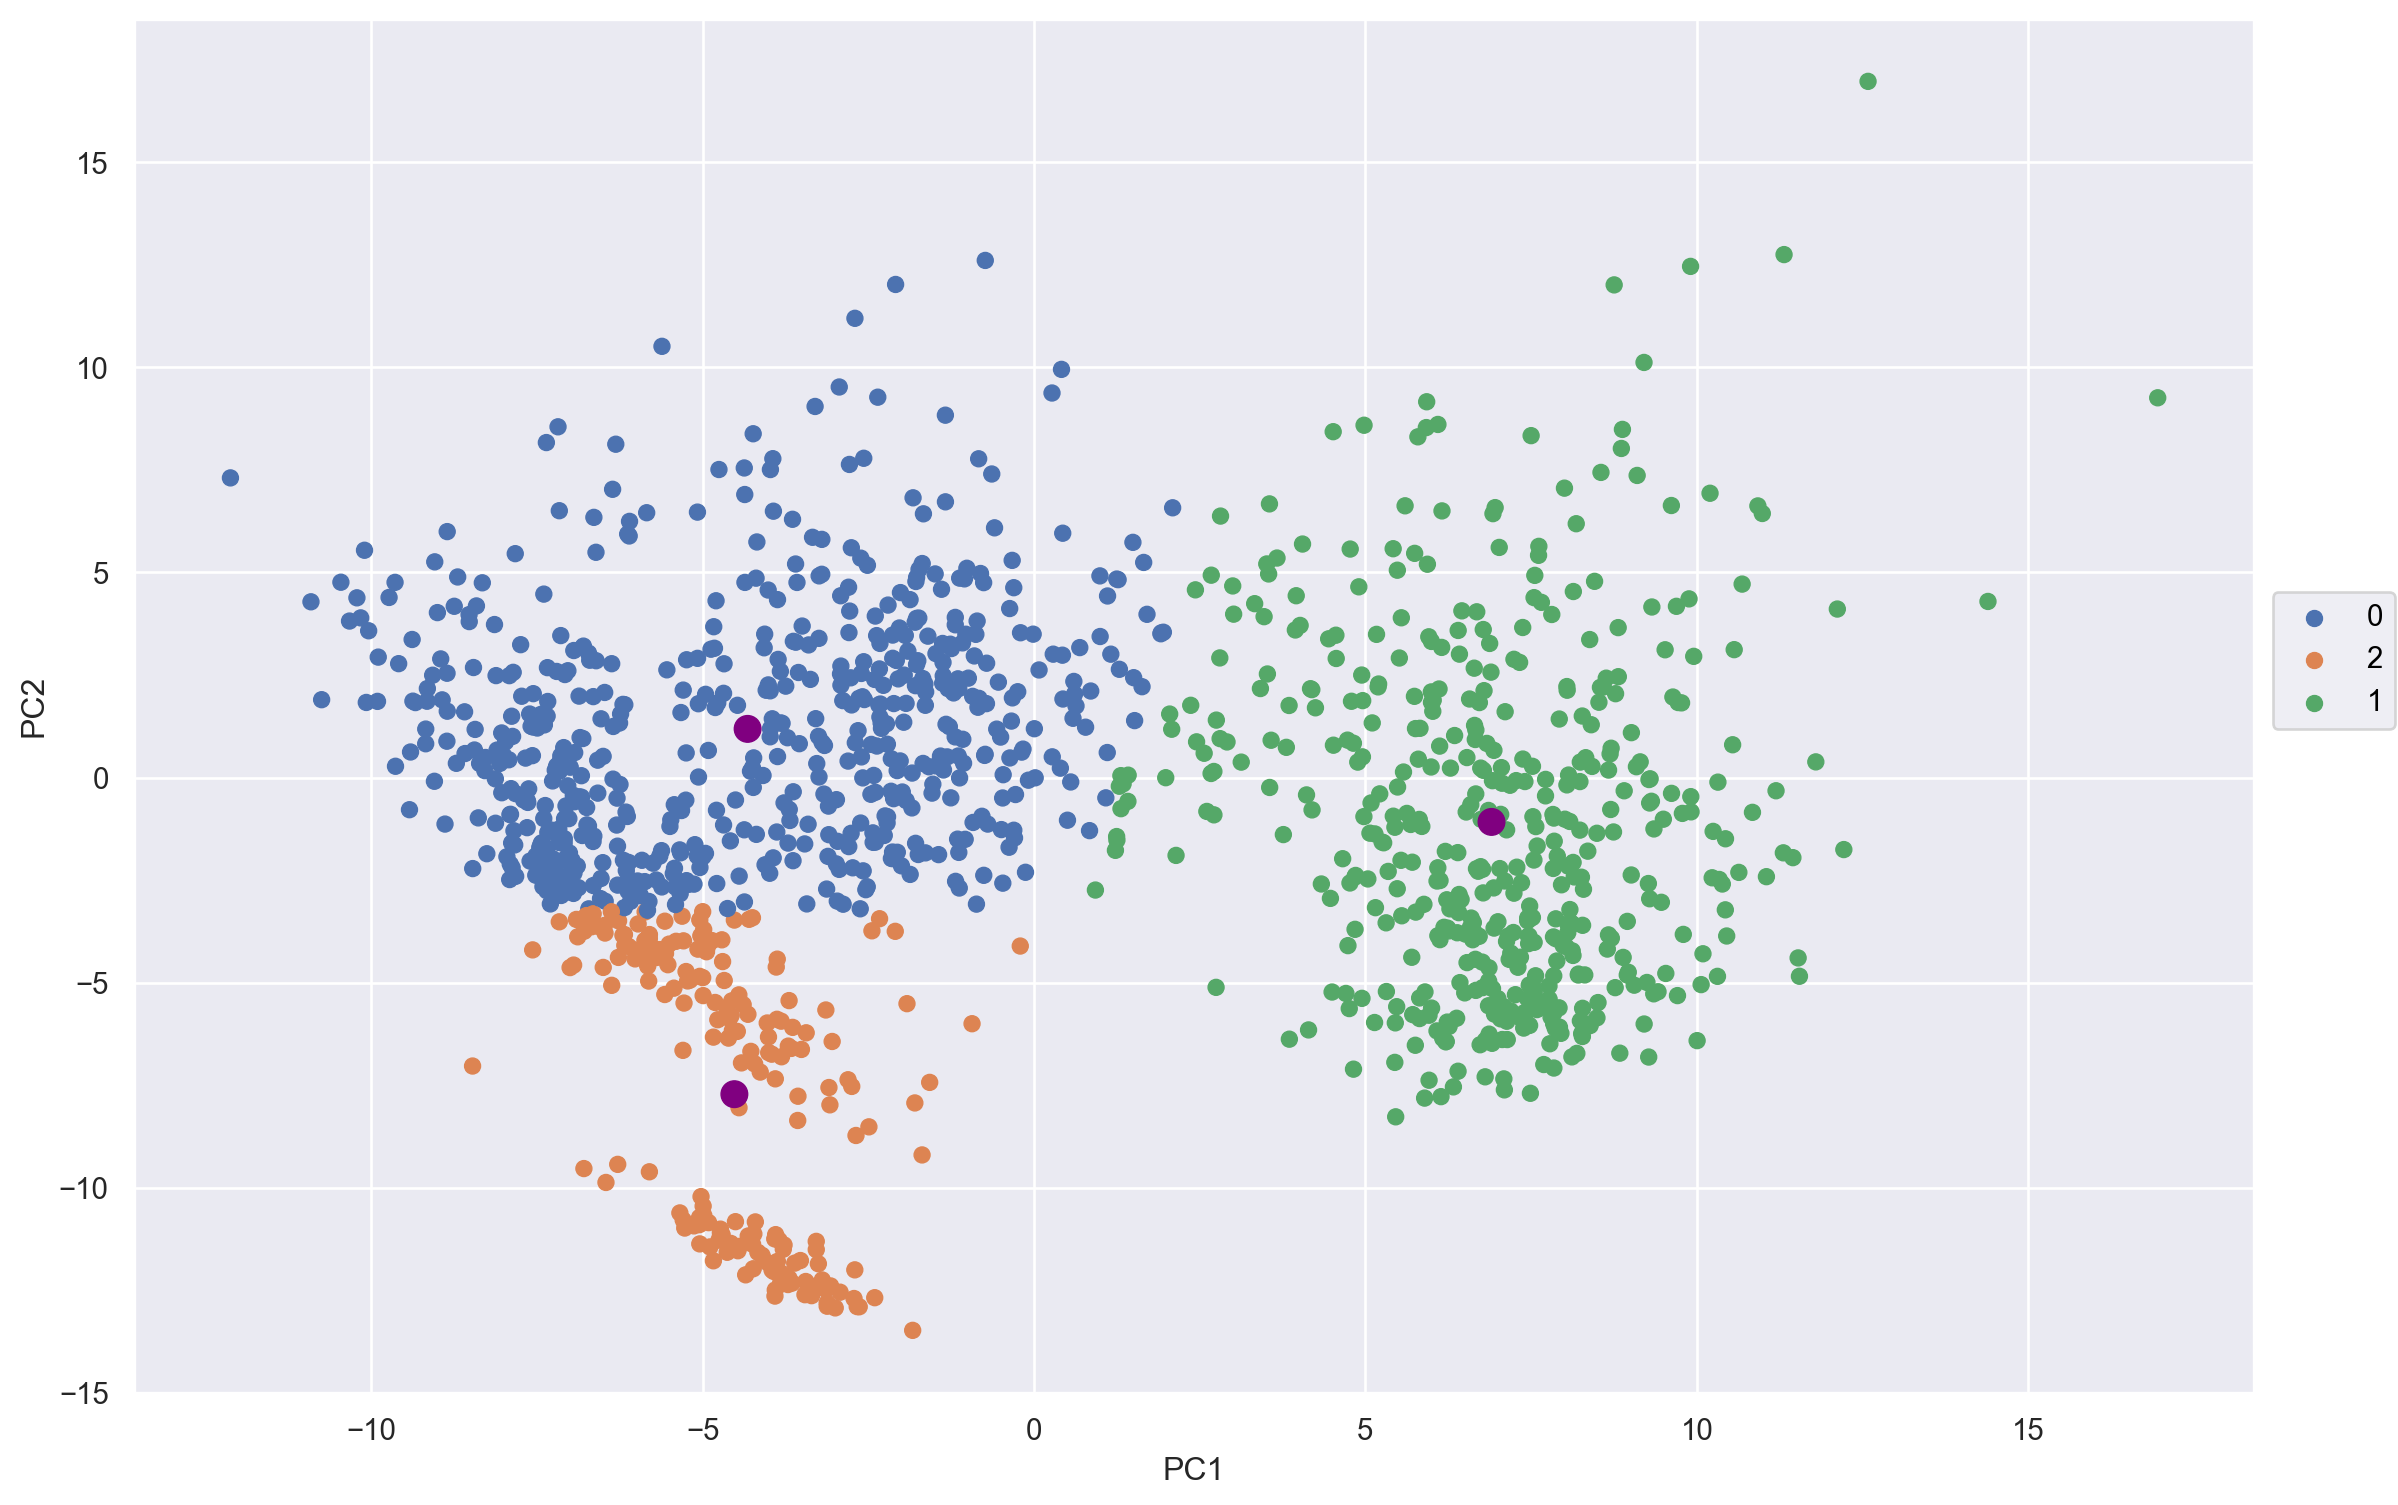

In [31]:
kmeans = KMeans(n_clusters=3)
cluster = kmeans.fit_predict(sin_med[["PC1","PC2"]])
(
    so.Plot()
    .add(so.Dot(),data=sin_med[["PC1","PC2"]],x="PC1",y="PC2",color=cluster.astype("str"))
    .layout(size=(12,8))
    .add(so.Dot(color = "purple", pointsize = 10), x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1])
)

Confirmamos que los mediocampisas tenian gran parte de la culpa de que en los clusters anteriores no se logren ver bien los diferentes agrupamientos. Aunque en este nuevo k-means observamos que el cluster del arquero se vio extendido por le mismo metodo interno de k-medias a la hora de realizar los grupos.

### Apartado(d)

Ahora vamos a realizar el metodo de clustering con DBSCAN.  
Para esto vamos a comenzar haciendo un grafico de densidad y asi poder intuir cual es el valor de nuestro hiperparametro eps.

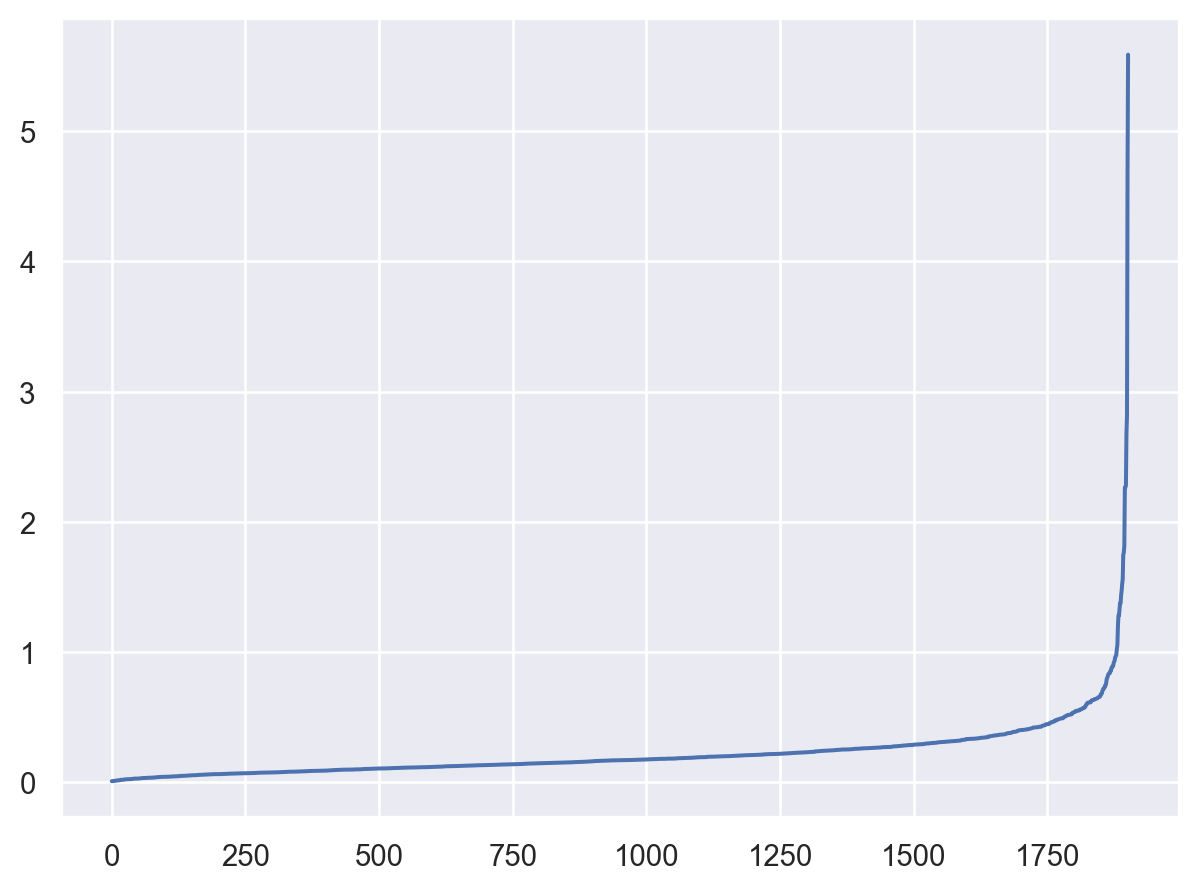

In [32]:
dataset = data_pca[["PC1","PC2"]]
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(dataset)
distances, indices = neighbors_fit.kneighbors(dataset)
distances = distances[:,1]
distances = np.sort(distances, axis=0)

so.Plot(x = np.arange(len(distances)), y = distances).add(so.Line())

yyy aca medio que podemos ver que nustro epsilon va a rondar los valores pertenecientes al intervalo [0.5,0.9].

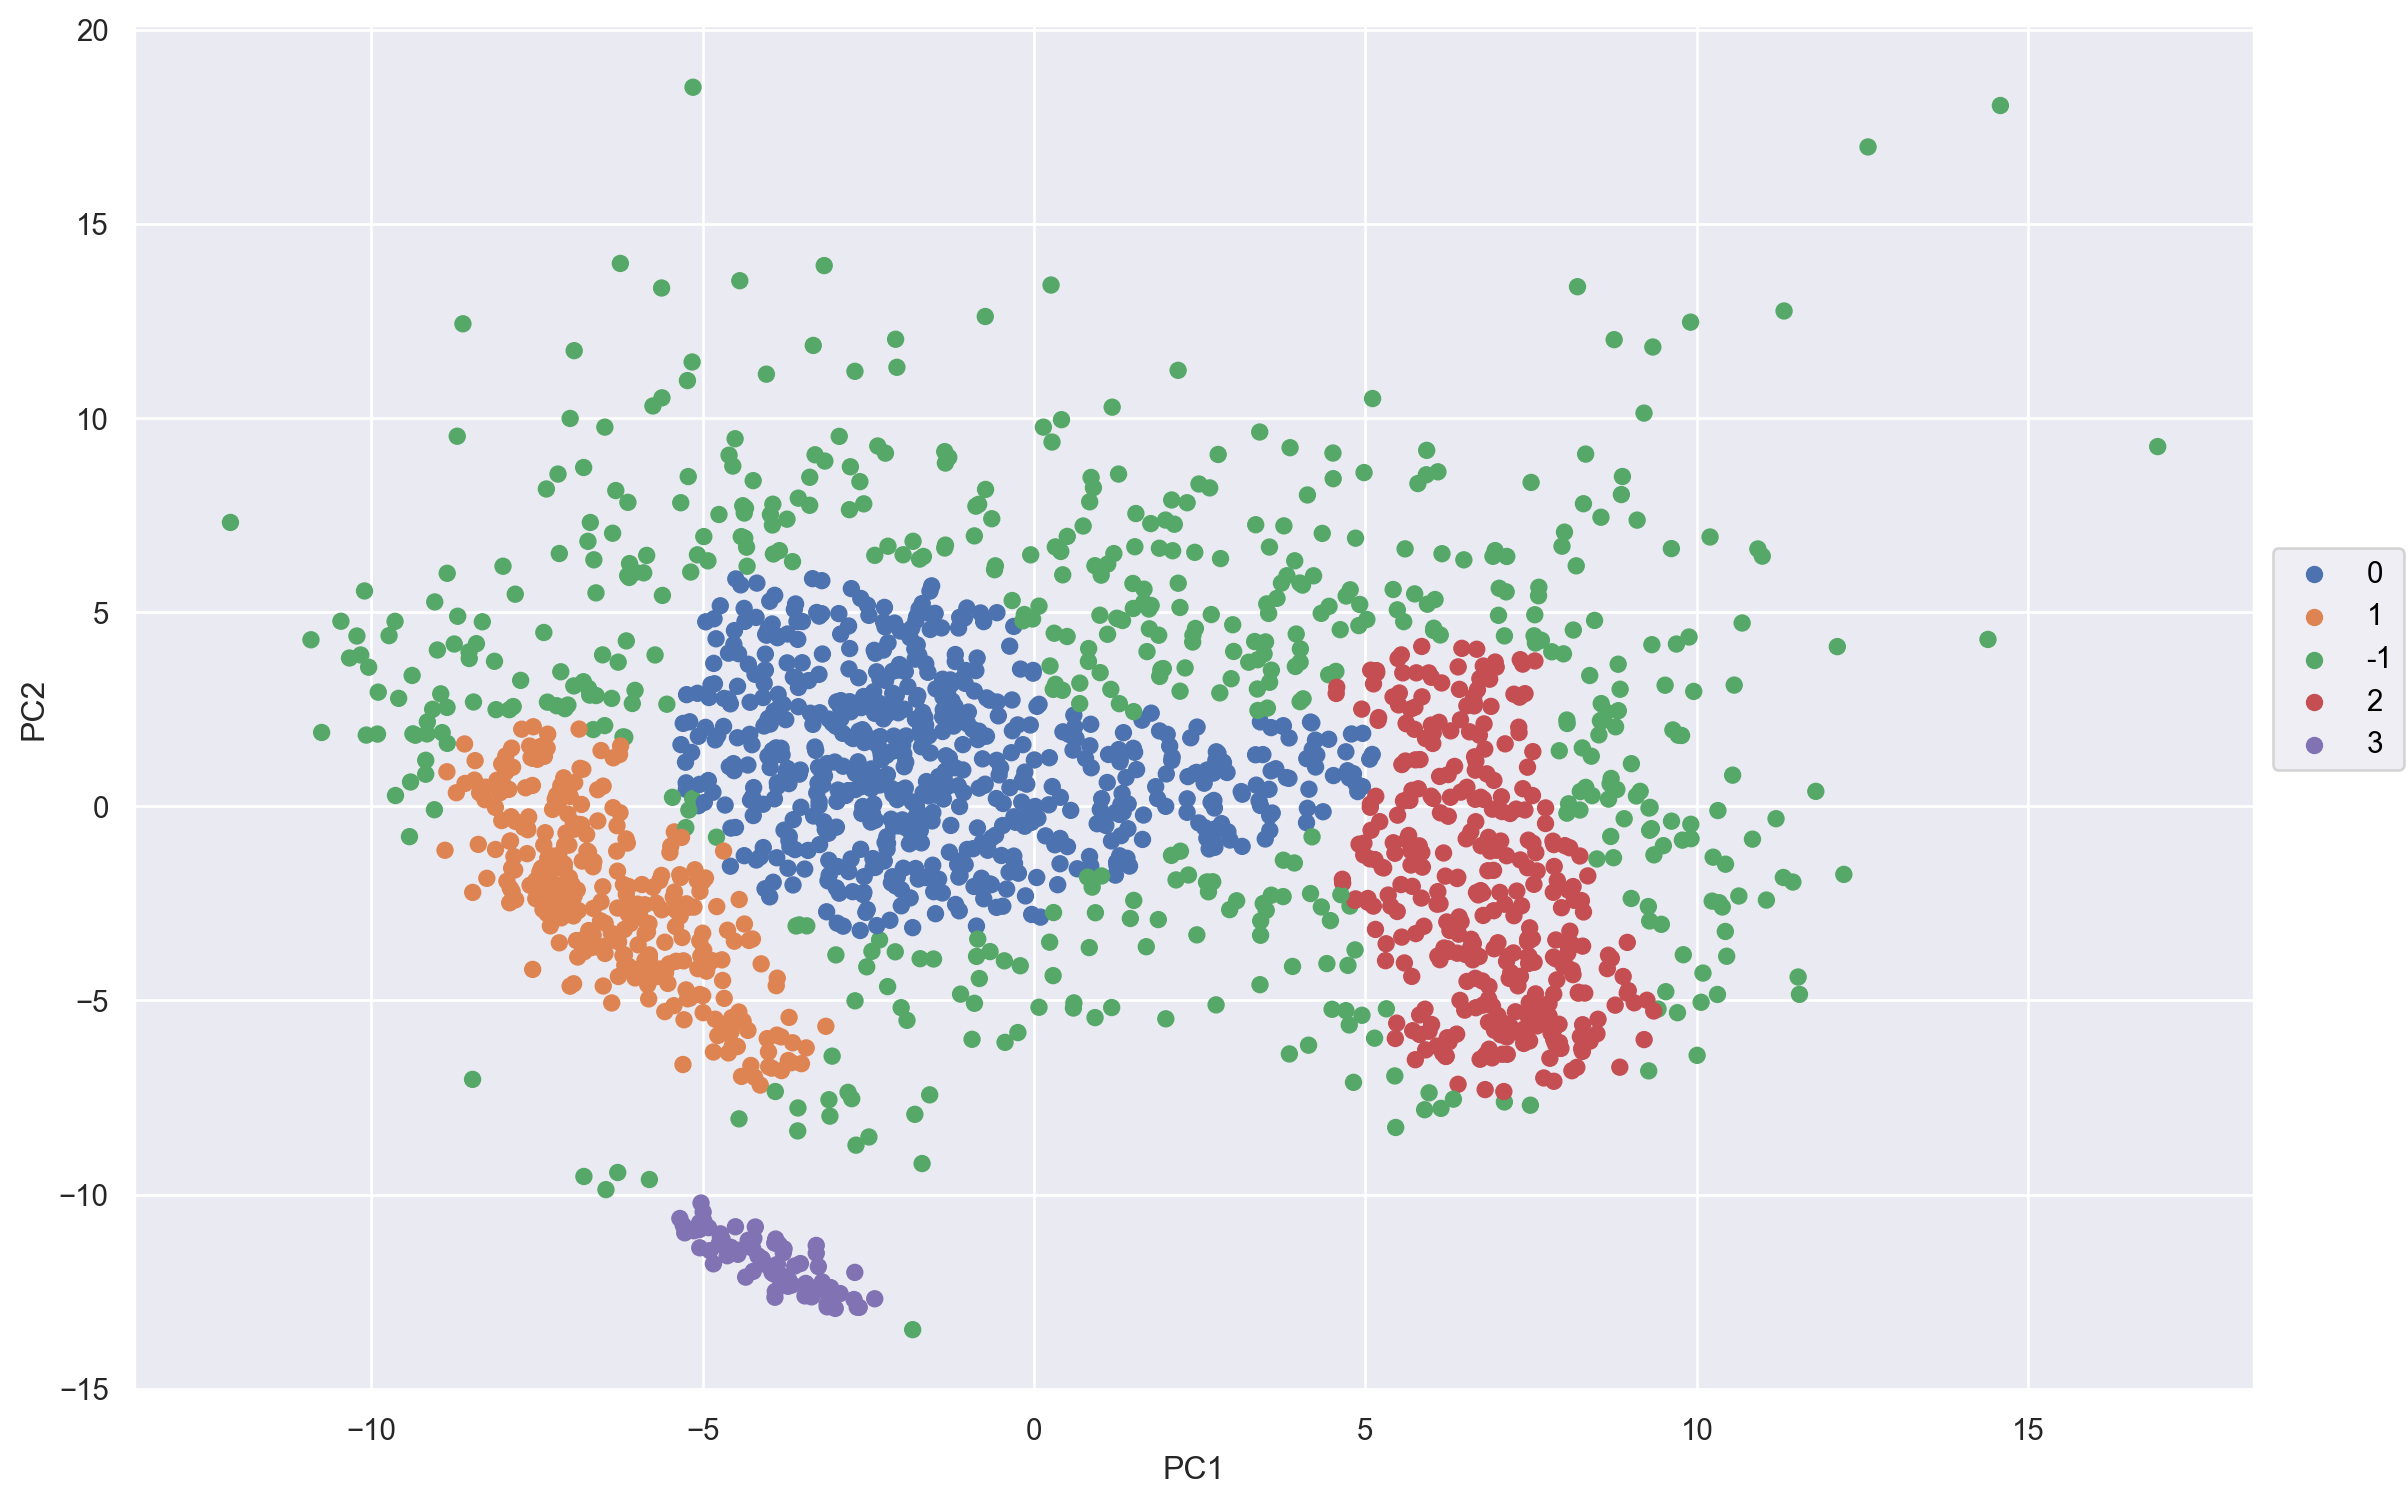

In [33]:
dbscan = DBSCAN(eps=0.9, min_samples=23)
etiqueta = dbscan.fit_predict(data_pca[["PC1","PC2"]])
(
    so.Plot(data_pca, x="PC1",y="PC2", color=etiqueta.astype("str"))
    .add(so.Dot())
    .layout(size=(12,8))
)

Llegamos a distinguir los diferentes grupos, no tan bien como lo esperabamos, pero es lo que conseguimos. vamos a ver que tan bien marcados estan los grupos, aunque le tenemos mucha más fe al siguiente modelo con todos las variables.

In [34]:
posicion_arq = (data_pca["pos_generica"]=="arquero") # Me deja True solo en los arqueros
posicion_def = (data_pca["pos_generica"]=="defensa") # Me deja True solo en los defensores
posicion_med = (data_pca["pos_generica"]=="medio") # Me deja True solo en los mediocampistas
posicion_del = (data_pca["pos_generica"]=="delantero") # Me deja True solo en los delanteros

In [35]:
arq_correcto = (posicion_arq==True)&(etiqueta == 3) # Me fijo los arqueros marcados correctamente
arq_correcto.sum()

75

In [36]:
arq_incorrecto = (posicion_arq==True)&((etiqueta == 0)|(etiqueta == 1)|(etiqueta == 2)|(etiqueta == -1)) # Me fijo los arqueros que no fueron marcados o fueron marcados de manera incorrecta
arq_incorrecto.sum()

6

In [37]:
def_correcto = (posicion_def==True)&(etiqueta == 1) # Me fijo los defensores marcados correctamente
def_correcto.sum()

291

In [38]:
def_incorrecto = (posicion_def==True)&((etiqueta == 0)|(etiqueta == 3)|(etiqueta == 2)|(etiqueta == -1)) # Me fijo los defensores que no fueron marcados o fueron marcados de manera incorrecta
def_incorrecto.sum()

471

In [39]:
med_correcto = (posicion_med==True)&(etiqueta == 0) # Me fijo los mediocampistas marcados correctamente
med_correcto.sum()

302

In [40]:
med_incorrecto = (posicion_med==True)&((etiqueta == 1)|(etiqueta == 3)|(etiqueta == 2)|(etiqueta == -1)) # Me fijo los mediocampistas que no fueron marcados o fueron marcados de manera incorrecta
med_incorrecto.sum()

301

In [41]:
del_correcto = (posicion_del==True)&(etiqueta == 2) # Me fijo los delanteros marcados correctamente
del_correcto.sum()

273

In [42]:
del_incorrecto = (posicion_del==True)&((etiqueta == 1)|(etiqueta == 3)|(etiqueta == 0)|(etiqueta == -1)) # Me fijo los delanteros que no fueron marcados o fueron marcados de manera incorrecta
del_incorrecto.sum()

183

In [43]:
(etiqueta==-1).sum() # vemos la cantidad de outliers

552

Vemos que hay muchos datos incorrectos debido a que fuimos a confirmar nuestra hipotesisi a la hora de encontrar los hiperparametros, dejandonos con un resultado poco satisfactorio.   
Ahora toca hacerlo con todas las variables. 

### Apartado (e)

In [44]:
data_num_esc = StandardScaler().set_output(transform="pandas").fit_transform(data_num) # Escalamos los datos
# Usamos StandardScaler en vez de MinMaxScaler debido a que en la parte anterior utilizamos ese

data_num_esc

Ast/90    npG/90  npG+A/90     xA/90   npxG/90  npxG+xA/90  Shots/90  \
0    -0.368990 -0.755263 -0.725773 -0.577198 -0.443008   -0.573851 -0.247304   
1    -0.839441 -0.164862 -0.537698 -0.949976 -0.519206   -0.793152 -0.726631   
2    -0.839441 -0.755263 -0.960866 -1.074236 -0.290611   -0.628676 -0.225516   
3    -0.839441 -0.296063 -0.631735 -0.701458 -0.519206   -0.683502 -0.519649   
4    -0.557170 -0.755263 -0.819810 -0.701458 -0.671603   -0.793152 -0.955400   
...        ...       ...       ...       ...       ...         ...       ...   
1897 -0.839441  0.163138 -0.302605 -1.074236 -0.214413   -0.628676 -0.029428   
1898  0.948273  0.491138  0.872860  0.292617  0.776165    0.687134  1.081739   
1899  0.760092  0.163138  0.496711  1.162432 -0.062016    0.413007 -0.116578   
1900  1.136453  0.622338  1.013916  0.665395  0.014182    0.303356  0.362748   
1901 -0.086719 -0.230463 -0.255586  0.044098  0.166579    0.084054  0.003253   

       SoTs/90  FKSht/90   np:G-xG  ...  PrgDistCarry/90  ProgCarry/90  \
0    -0.219636  0.978454 -0.735460  ...        -0.074387      0.783800   
1    -0.582580 -0.402602  0.555225  ...         0.648976     -0.939363   
2    -0.452957 -0.402602 -1.122665  ...         0.378520     -1.229443   
3    -0.608505 -0.402602  0.297088  ...        -0.162393     -0.320237   
4    -0.997373 -0.402602 -0.348254  ...         1.417415     -0.116748   
...        ...       ...       ...  ...              ...           ...   
1897 -0.634429 -0.402602  0.813362  ...        -0.514415     -0.220657   
1898  1.180290 -0.402602 -0.348254  ...         0.818548      2.048030   
1899  0.065534 -0.126391  0.426157  ...         0.891528      1.502506   
1900  0.635874  0.241891  1.200568  ...         0.037230      0.545674   
1901  0.376629 -0.402602 -0.735460  ...         0.365641      0.571652   

      CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0              0.374041         0.212073      -0.555069        -0.358168   
1             -1.135684        -0.722041      -0.972806        -0.752355   
2             -1.349661        -0.787212      -1.084881        -1.216105   
3             -0.648293        -0.787212      -1.003372        -1.297261   
4             -0.220339        -0.722041      -0.769032        -0.995824   
...                 ...              ...            ...              ...   
1897           0.219502         0.125179      -0.239220        -0.172669   
1898           0.944645         1.450318       1.003800         1.693922   
1899           1.562800         1.602383       1.126065         2.018547   
1900           0.231389         1.645830       1.767952         1.543204   
1901           0.552354        -0.135504       0.392479         1.160611   

      PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0         -0.179105           0.163181  0.611653            -0.322380  
1         -0.063129           0.408780  0.896226            -1.015380  
2         -0.844036          -0.328019  0.943654            -1.087295  
3         -0.758986          -0.289644  0.828470            -0.894432  
4          0.485825           0.946029  0.916552            -0.858475  
...             ...                ...       ...                  ...  
1897      -1.045061          -1.241342 -1.109331            -0.178550  
1898       1.042511           0.546930 -0.513084             1.612789  
1899       0.354385          -0.128469 -0.790881             1.596444  
1900      -0.333740          -0.704093 -0.980596             0.923058  
1901       0.454898           0.332030 -0.106552             0.226789  

[1902 rows x 106 columns]

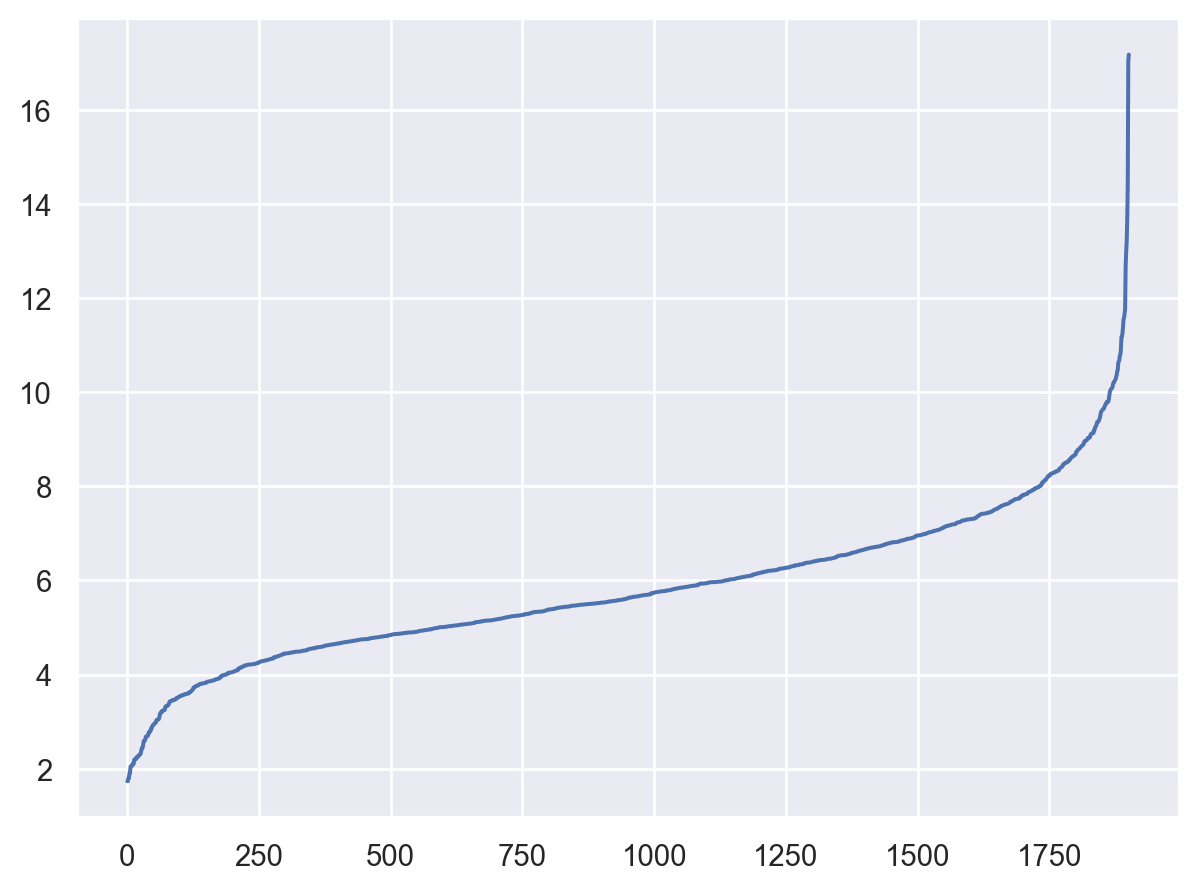

In [45]:
dataset = data_num_esc
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(dataset)
distances, indices = neighbors_fit.kneighbors(dataset)
distances = distances[:,1]
distances = np.sort(distances, axis=0)

so.Plot(x = np.arange(len(distances)), y = distances).add(so.Line())

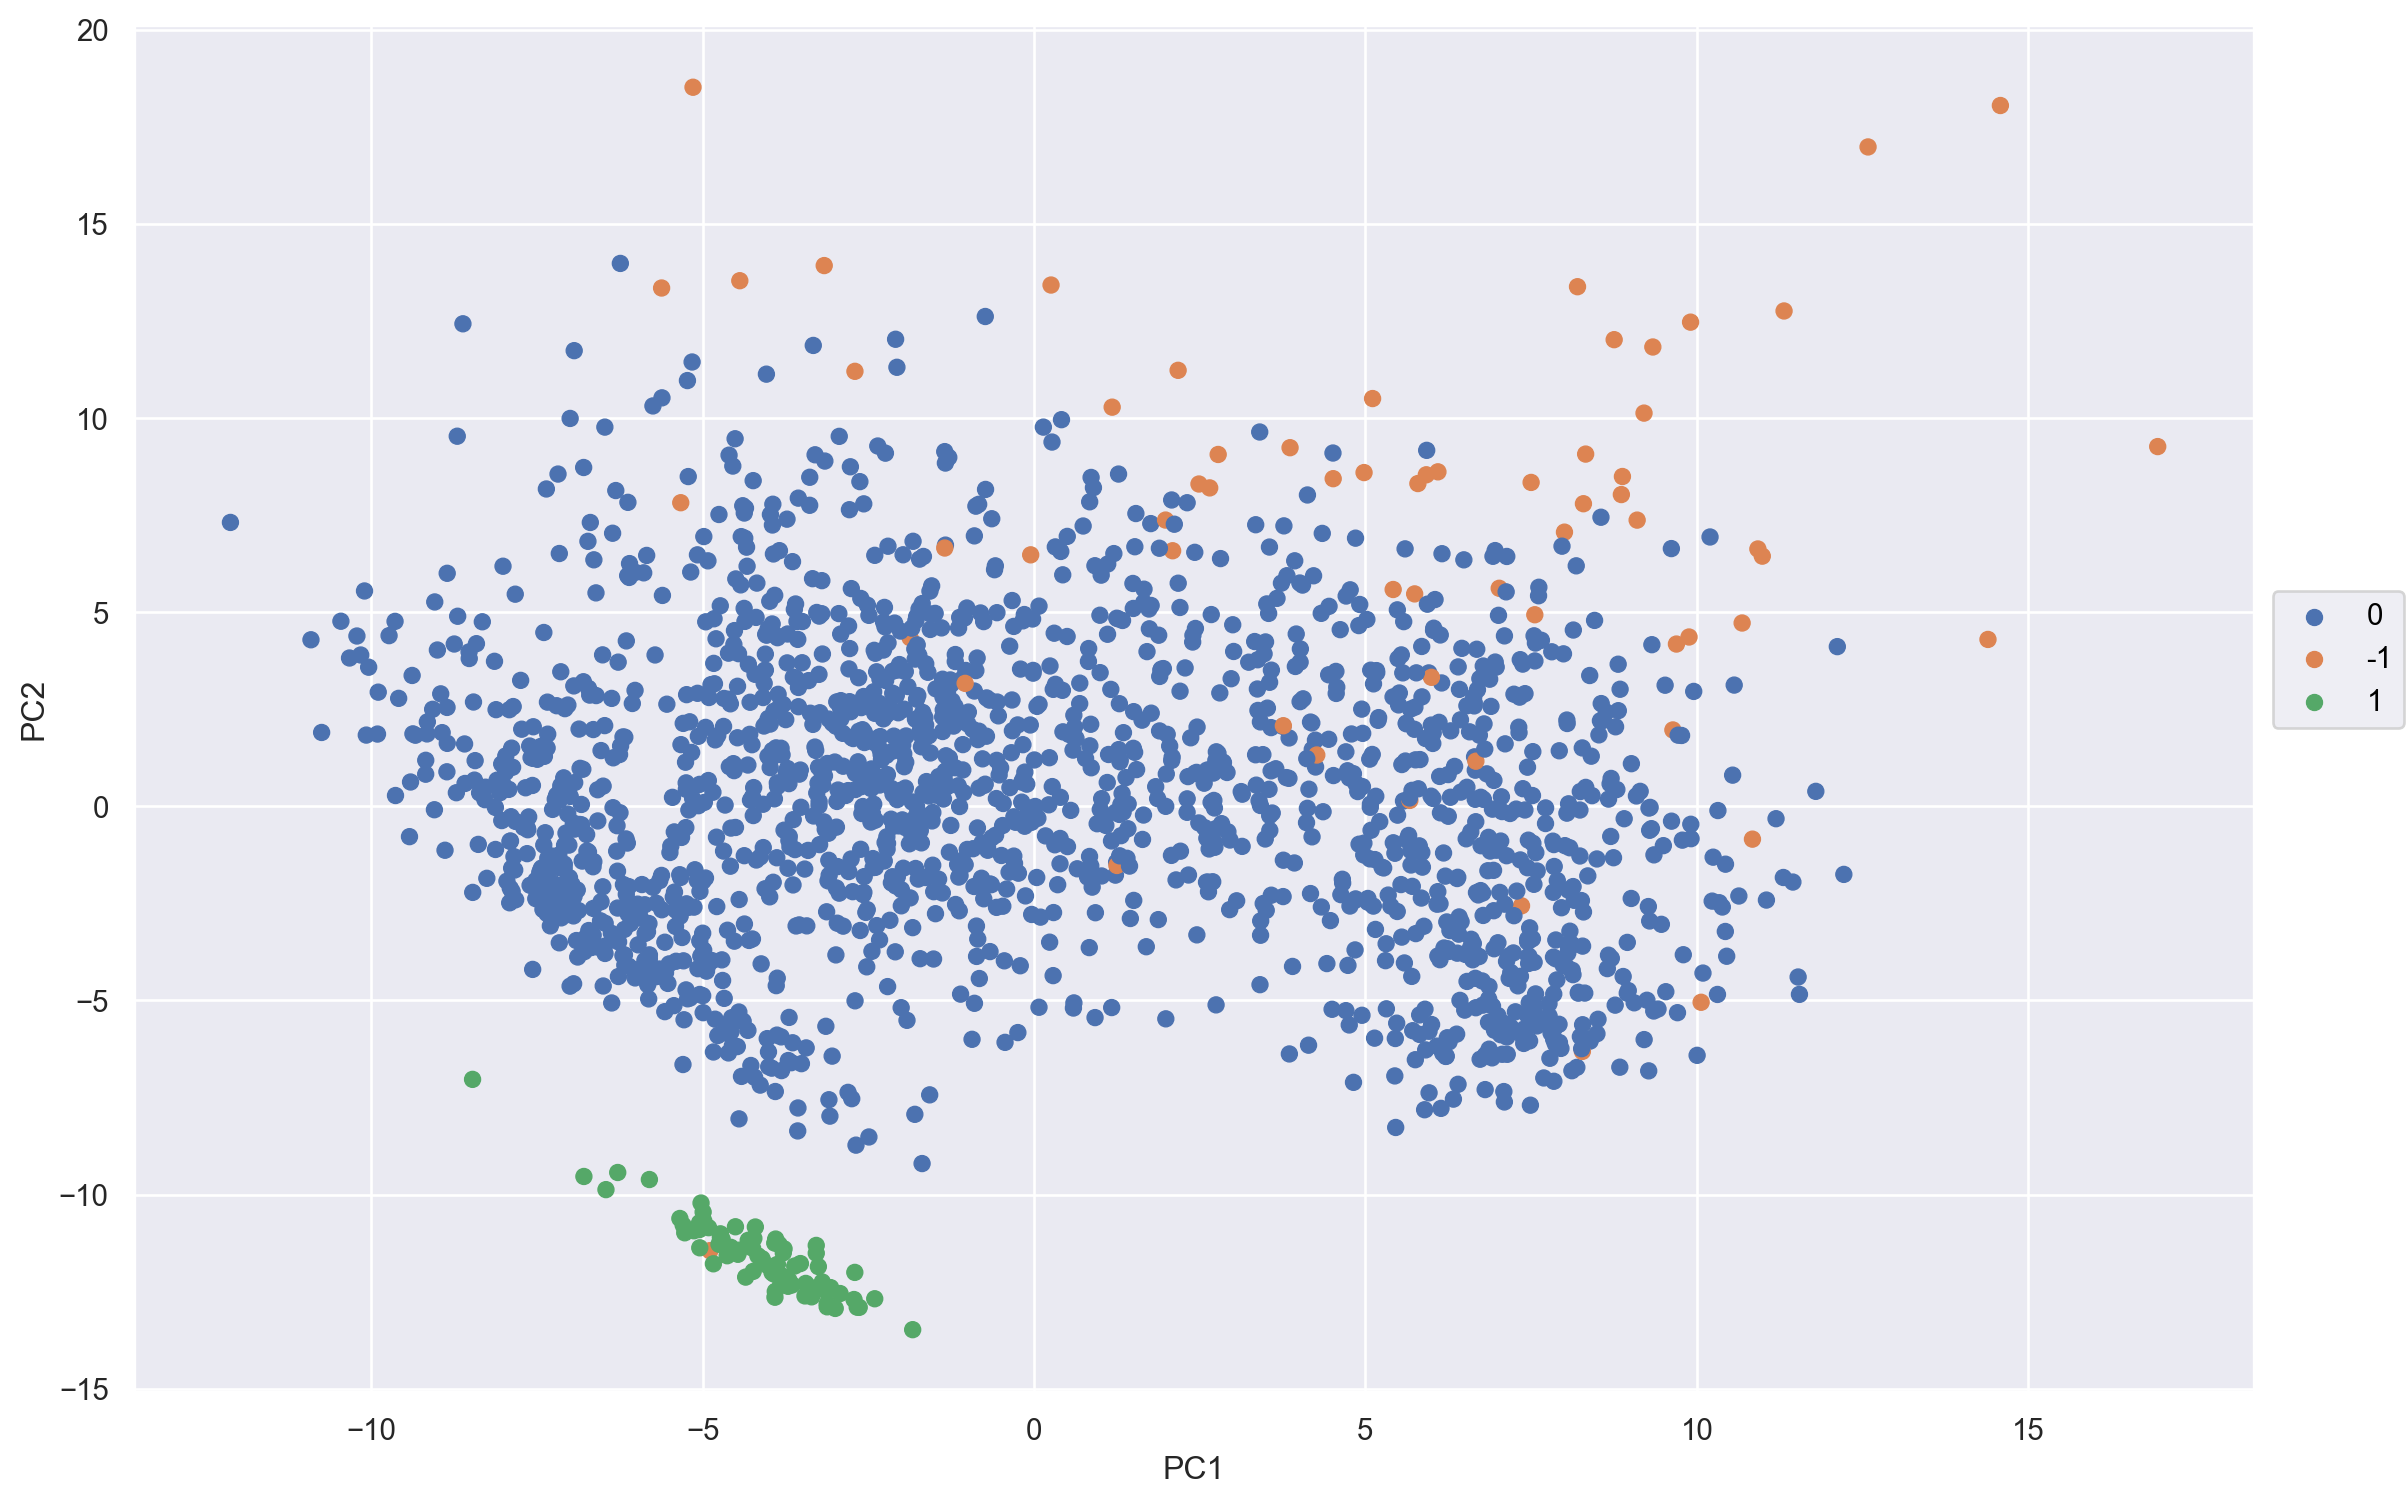

In [46]:
dbscan = DBSCAN(eps=9.5, min_samples=25)
etiqueta = dbscan.fit_predict(data_num_esc)
(
    so.Plot(data_pca, x="PC1",y="PC2", color=etiqueta.astype("str"))
    .add(so.Dot())
    .layout(size=(12,8))
)

Nos gusto más este resultado de DBSCAN porque si bien no podemos distinguir las 4 posiciones podemos ver bien quienes son arqueros y quienes jugadores de campo, sumado que tenemos pocos outliers.  Ahora vamos a ver cuantos outliers tenemos, cuantos datos son correctos y erroneos.

In [47]:
posicion = (data_pca["pos_generica"]=="arquero") # Me deja True solo en los arqueros

In [48]:
arq_incorrecto = (posicion==True)&((etiqueta == 0)|(etiqueta == -1)) # Marco los arqueros que no fueron marcados
arq_incorrecto.sum()

1

In [49]:
arq_correcto = (posicion==True)&(etiqueta == 1) # Me fijo los arqueros marcados correctamente
arq_correcto.sum()

80

In [50]:
campo_incorrecto = (posicion==False)&((etiqueta == 1)|(etiqueta == -1)) # Marco los jugadores de campo que no fueron marcados
campo_incorrecto.sum()

63

In [51]:
campo_correcto = (posicion==False)&(etiqueta == 0) # Me fijo los jugadores de campo marcados correctamente
campo_correcto.sum()

1758

In [52]:
(etiqueta == -1).sum()

64

Confirmamos que el ultimo modelo de DBSCAN entrenado con todos las variables esta muy bueno para distinguir los grupos de jugadores de campo y los arqueros, dejandonos con ningun jugador mal marcado debido a que todos los incorrectos son outliers.   

# PARTE 3 (Clasificación)

## Ejercicio 7

Vamos a armar un modelo de KNN para predecir la posicion de un jugador basado en las estadisticas del Dataframe.

### Apartado (a y b)

In [53]:
Pos_filterer_alt=[] # Creamos la columna Pos_fil 
for i in range(len(estadisticas_20_21)):
  if len(estadisticas_20_21.iloc[i]['Pos'])>2:
    Pos_filterer_alt.append(estadisticas_20_21.iloc[i]['Pos'][:2:])
  else:
    Pos_filterer_alt.append(estadisticas_20_21.iloc[i]['Pos'])
Pos_filt=pd.DataFrame(Pos_filterer_alt)

Lo primero que vamos a hacer es escalar los datos (KNN es sensible a las escalas).  
Decidimos escalar todo porque no sabemos que variables vamos a utilizar todavida.

In [54]:
data_clasif=data_num.copy()
data_clasif = MinMaxScaler().set_output(transform="pandas").fit_transform(data_clasif) #Escalado de DataFrame
data_clasif.insert(0,'Pos_filt', Pos_filt[0]) # Insertamos la columna Pos_filt al principio de todo
data_clasif

Pos_filt    Ast/90  npG/90  npG+A/90     xA/90   npxG/90  npxG+xA/90  \
0          DF  0.065789   0.000  0.029586  0.074074  0.066667    0.086207   
1          DF  0.000000   0.072  0.053254  0.018519  0.055556    0.051724   
2          DF  0.000000   0.000  0.000000  0.000000  0.088889    0.077586   
3          DF  0.000000   0.056  0.041420  0.055556  0.055556    0.068966   
4          DF  0.039474   0.000  0.017751  0.055556  0.033333    0.051724   
...       ...       ...     ...       ...       ...       ...         ...   
1897       MF  0.000000   0.112  0.082840  0.000000  0.100000    0.077586   
1898       MF  0.250000   0.152  0.230769  0.203704  0.244444    0.284483   
1899       MF  0.223684   0.112  0.183432  0.333333  0.122222    0.241379   
1900       MF  0.276316   0.168  0.248521  0.259259  0.133333    0.224138   
1901       MF  0.105263   0.064  0.088757  0.166667  0.155556    0.189655   

      Shots/90   SoTs/90  FKSht/90  ...  PrgDistCarry/90  ProgCarry/90  \
0     0.161062  0.118577  0.126050  ...         0.311029      0.375974   
1     0.083186  0.063241  0.000000  ...         0.426314      0.117532   
2     0.164602  0.083004  0.000000  ...         0.383210      0.074026   
3     0.116814  0.059289  0.000000  ...         0.297003      0.210390   
4     0.046018  0.000000  0.000000  ...         0.548782      0.240909   
...        ...       ...       ...  ...              ...           ...   
1897  0.196460  0.055336  0.000000  ...         0.240900      0.225325   
1898  0.376991  0.332016  0.000000  ...         0.453339      0.565584   
1899  0.182301  0.162055  0.025210  ...         0.464970      0.483766   
1900  0.260177  0.249012  0.058824  ...         0.328818      0.340260   
1901  0.201770  0.209486  0.000000  ...         0.381158      0.344156   

      CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0              0.266200         0.138138       0.122677            0.162   
1              0.043783         0.009009       0.046468            0.094   
2              0.012259         0.000000       0.026022            0.014   
3              0.115587         0.000000       0.040892            0.000   
4              0.178634         0.009009       0.083643            0.052   
...                 ...              ...            ...              ...   
1897           0.243433         0.126126       0.180297            0.194   
1898           0.350263         0.309309       0.407063            0.516   
1899           0.441331         0.330330       0.429368            0.572   
1900           0.245184         0.336336       0.546468            0.490   
1901           0.292469         0.090090       0.295539            0.424   

      PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0          0.365111           0.356109  0.886792             0.151948  
1          0.380132           0.390166  0.952830             0.014286  
2          0.278991           0.287995  0.963836             0.000000  
3          0.290006           0.293316  0.937107             0.038312  
4          0.451232           0.464666  0.957547             0.045455  
...             ...                ...       ...                  ...  
1897       0.252954           0.161345  0.487421             0.180519  
1898       0.523333           0.409323  0.625786             0.536364  
1899       0.434208           0.315666  0.561321             0.533117  
1900       0.345083           0.235845  0.517296             0.399351  
1901       0.447226           0.379523  0.720126             0.261039  

[1902 rows x 107 columns]

Ahora dividimos la tabla de data_clasif en 80% Train y 20% Test. Aprovechamos y para el train utilizamos "data_num" y para test la columna de "Pos_filt"

In [55]:
data_num_esc = StandardScaler().set_output(transform="pandas").fit_transform(data_num) # Escalamos "data_num"
X_train, X_test, y_train, y_test= train_test_split(data_num_esc,data_clasif['Pos_filt'], test_size=0.2, random_state=20)

### Apartado (c y d)

In [56]:
cv_scores = []
k_range = range(1, 21)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy')
    cv_scores.append((k,scores.mean()))
cv_scores

[(1, 0.8869240724762728),
 (2, 0.8836238136324418),
 (3, 0.9033498705780845),
 (4, 0.9026898188093184),
 (5, 0.9086065573770492),
 (6, 0.9072972389991371),
 (7, 0.9119003451251079),
 (8, 0.9079594477998274),
 (9, 0.9099288179465056),
 (10, 0.911902502157032),
 (11, 0.9099331320103538),
 (12, 0.9105953408110439),
 (13, 0.9138826574633304),
 (14, 0.911904659188956),
 (15, 0.9171613459879205),
 (16, 0.91255823986195),
 (17, 0.9171613459879205),
 (18, 0.9158455565142365),
 (19, 0.9158477135461605),
 (20, 0.9151855047454702)]

In [57]:
knn = KNeighborsClassifier(n_neighbors=15) 
knn.fit(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)
print(test_accuracy)

0.916010498687664


Conseguimos un gran modelo con un porcentaje de aciertos del 91,6% en nuestro conjunto de test.

### Apartado (e)

In [58]:
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(data_num_esc)


In [59]:
data_pca = pd.DataFrame(data=componentes_principales, columns=['PC1', 'PC2'])

Vamos a utilizar los mismos casos de entrenamiento que antes.

In [60]:
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)

In [61]:
cv_scores = []
k_range = range(1, 20)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, scoring='accuracy')
    cv_scores.append(scores.mean())
cv_scores

[0.7093960310612597,
 0.702174288179465,
 0.7297756686798965,
 0.731753666954271,
 0.7376574633304573,
 0.7383261432269197,
 0.7534426229508195,
 0.7488352027610008,
 0.7494887834339948,
 0.7488481449525454,
 0.7534490940465919,
 0.7501574633304573,
 0.7429249352890424,
 0.7488459879206213,
 0.7442450388265747,
 0.7468766177739431,
 0.7455629853321829,
 0.750834771354616,
 0.7501704055220018]

In [62]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_pca, y_train)
test_accuracy = knn.score(X_test_pca, y_test)
print(test_accuracy)

0.6929133858267716


Notamos que el modelo anterior tuvo un mejor resultado en comparacion al hecho utilizando la primeras dos componentes principales.

## Ejercicio 8

Ahora toca hacer lo mismo pero con los datos de la liga femenina

In [63]:
liga_fem = pd.read_csv("superleague2023.csv")
liga_fem.columns 

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP', 'Starts',
       'Min', '90s', 'Performance_Gls', 'Performance_Ast', 'Performance_G+A',
       'Performance_G-PK', 'Performance_PK', 'Performance_PKatt',
       'Performance_CrdY', 'Performance_CrdR', 'Expected_xG', 'Expected_npxG',
       'Expected_xAG', 'Expected_npxG+xAG', 'PrgC', 'PrgP', 'PrgR',
       'Per90Minutes_Gls', 'Per90Minutes_Ast', 'Per90Minutes_G+A',
       'Per90Minutes_G-PK', 'Per90Minutes_G+A-PK', 'Per90Minutes_xG',
       'Per90Minutes_xAG', 'Per90Minutes_xG+xAG', 'Per90Minutes_npxG',
       'Per90Minutes_npxG+xAG '],
      dtype='object')

In [64]:
liga_fem_num =pd.DataFrame() #Al igual que con el masculino elimino las primeras columnas 
pase = False
for x in liga_fem.columns:
    if x=="MP": #(Cambiar "MP" por "Performance_Gls") Markdown más adelante explicando, si no se ha llegado, no hacerlo aun
        pase=True
    if pase:
        liga_fem_num[x]=liga_fem[[x]]

In [65]:
liga_fem_num.info() # El dato de los minutos es de tipo object, asi que a pesar de que la consigna no lo pide la vamos a eliminar para poder escalar los datos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MP                      304 non-null    int64  
 1   Starts                  304 non-null    int64  
 2   Min                     304 non-null    object 
 3   90s                     304 non-null    float64
 4   Performance_Gls         304 non-null    int64  
 5   Performance_Ast         304 non-null    int64  
 6   Performance_G+A         304 non-null    int64  
 7   Performance_G-PK        304 non-null    int64  
 8   Performance_PK          304 non-null    int64  
 9   Performance_PKatt       304 non-null    int64  
 10  Performance_CrdY        304 non-null    int64  
 11  Performance_CrdR        304 non-null    int64  
 12  Expected_xG             304 non-null    float64
 13  Expected_npxG           304 non-null    float64
 14  Expected_xAG            304 non-null    fl

In [66]:
liga_fem_num = liga_fem_num.select_dtypes(exclude=["object"]) #Eliminamos las columnas de tipo object

In [67]:
liga_fem_num.isnull().any().sum() # No hay columnas con datos faltantes 

0

Ahora con todo lo necesario chequeado ya estamos listos para trabajar, solo nos falta agregar la columna con la posición.

In [68]:
Pos_filterer_fem=[] # Creamos la columna Pos_fil_fem con las posiciones a utilizar
for i in range(len(liga_fem_num)):
  if len(liga_fem.iloc[i]['Pos'])>2:
    Pos_filterer_fem.append(liga_fem.iloc[i]['Pos'][:2:])
  else:
    Pos_filterer_fem.append(liga_fem.iloc[i]['Pos'])
Pos_filt_fem=pd.DataFrame(Pos_filterer_fem)

In [69]:
data_clasif_fem=liga_fem_num.copy()
data_clasif_fem = MinMaxScaler().set_output(transform="pandas").fit_transform(data_clasif_fem) #Escalado de DataFrame
data_clasif_fem.insert(0,'Pos_filt', Pos_filt_fem[0]) # Insertamos la columna Pos_filt_fem al principio de todo
data_clasif_fem

Pos_filt        MP    Starts       90s  Performance_Gls  Performance_Ast  \
0         MF  0.476190  0.000000  0.045455         0.000000            0.125   
1         FW  0.000000  0.000000  0.004545         0.000000            0.000   
2         MF  0.000000  0.000000  0.000000         0.000000            0.000   
3         MF  0.714286  0.454545  0.468182         0.047619            0.250   
4         DF  0.238095  0.181818  0.150000         0.000000            0.000   
..       ...       ...       ...       ...              ...              ...   
299       DF  0.047619  0.045455  0.059091         0.000000            0.000   
300       MF  1.000000  1.000000  1.000000         0.047619            0.750   
301       MF  0.904762  0.818182  0.790909         0.000000            0.125   
302       GK  0.809524  0.818182  0.818182         0.000000            0.000   
303       MF  0.714286  0.500000  0.445455         0.000000            0.125   

     Performance_G+A  Performance_G-PK  Performance_PK  Performance_PKatt  \
0           0.041667          0.000000        0.000000           0.000000   
1           0.000000          0.000000        0.000000           0.000000   
2           0.000000          0.000000        0.000000           0.000000   
3           0.125000          0.047619        0.000000           0.000000   
4           0.000000          0.000000        0.000000           0.000000   
..               ...               ...             ...                ...   
299         0.000000          0.000000        0.000000           0.000000   
300         0.291667          0.000000        0.333333           0.333333   
301         0.041667          0.000000        0.000000           0.000000   
302         0.000000          0.000000        0.000000           0.000000   
303         0.041667          0.000000        0.000000           0.000000   

     ...  Per90Minutes_Gls  Per90Minutes_Ast  Per90Minutes_G+A  \
0    ...          0.000000          0.332258          0.160187   
1    ...          0.000000          0.000000          0.000000   
2    ...          0.000000          0.000000          0.000000   
3    ...          0.015552          0.064516          0.045101   
4    ...          0.000000          0.000000          0.000000   
..   ...               ...               ...               ...   
299  ...          0.000000          0.000000          0.000000   
300  ...          0.007776          0.087097          0.049767   
301  ...          0.000000          0.019355          0.009331   
302  ...          0.000000          0.000000          0.000000   
303  ...          0.000000          0.032258          0.015552   

     Per90Minutes_G-PK  Per90Minutes_G+A-PK  Per90Minutes_xG  \
0             0.000000             0.160187         0.014354   
1             0.000000             0.000000         0.000000   
2             0.000000             0.000000         0.000000   
3             0.015552             0.045101         0.019139   
4             0.000000             0.000000         0.028708   
..                 ...                  ...              ...   
299           0.000000             0.000000         0.000000   
300           0.000000             0.041991         0.033493   
301           0.000000             0.009331         0.014354   
302           0.000000             0.000000         0.000000   
303           0.000000             0.015552         0.043062   

     Per90Minutes_xAG  Per90Minutes_xG+xAG  Per90Minutes_npxG  \
0            0.000000             0.007075           0.014354   
1            0.000000             0.000000           0.000000   
2            0.000000             0.000000           0.000000   
3            0.028302             0.035377           0.019139   
4            0.000000             0.014151           0.028708   
..                ...                  ...                ...   
299          0.000000             0.000000           0.000000   
300          0.063679             0.

Bueno, ahora vamos a comenzar el ejercicio empezando por dividir los casoso de entrenamiento y testeo :)

In [70]:
liga_fem_esc = StandardScaler().set_output(transform="pandas").fit_transform(liga_fem_num) # Escalamos "liga_frm_num"
X_train_fem, X_test_fem, y_train_fem, y_test_fem= train_test_split(liga_fem_esc,data_clasif_fem['Pos_filt'], test_size=0.2, random_state=20)

In [71]:
cv_scores_fem = []
k_range_fem = range(1, 20)
for k in k_range_fem:
    knn_fem = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_fem, X_train_fem, y_train_fem, scoring='accuracy')
    cv_scores_fem.append((k,scores.mean()))
cv_scores_fem

[(1, 0.5430272108843537),
 (2, 0.5761904761904761),
 (3, 0.5886054421768707),
 (4, 0.6258503401360545),
 (5, 0.6214285714285714),
 (6, 0.5889455782312925),
 (7, 0.6218537414965986),
 (8, 0.6261054421768708),
 (9, 0.625765306122449),
 (10, 0.638095238095238),
 (11, 0.6051020408163266),
 (12, 0.6173469387755102),
 (13, 0.6173469387755102),
 (14, 0.6090136054421769),
 (15, 0.605017006802721),
 (16, 0.6093537414965986),
 (17, 0.5928571428571429),
 (18, 0.6051020408163266),
 (19, 0.625765306122449)]

In [72]:
knn = KNeighborsClassifier(n_neighbors=8) 
knn.fit(X_train_fem, y_train_fem)
test_accuracy = knn.score(X_test_fem, y_test_fem)
print(test_accuracy)

0.5901639344262295


Este modelo no quedo tan bueno como el masculino, dejandonos en un porcentaje de acierto del 59% en los casos de test.

In [73]:
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(liga_fem_esc)

In [74]:
data_pca = pd.DataFrame(data=componentes_principales, columns=['PC1', 'PC2'])

In [75]:
X_train_pca=pca.fit_transform(X_train_fem)
X_test_pca=pca.transform(X_test_fem)

In [76]:
cv_scores = []
k_range = range(1, 20)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train_fem, scoring='accuracy')
    cv_scores.append(scores.mean())
cv_scores

[0.5760204081632654,
 0.5018707482993197,
 0.5599489795918368,
 0.5393707482993197,
 0.5352040816326531,
 0.5599489795918366,
 0.5517857142857142,
 0.5640306122448979,
 0.5642006802721089,
 0.5681972789115647,
 0.551530612244898,
 0.5555272108843538,
 0.530952380952381,
 0.5472789115646258,
 0.5349489795918367,
 0.5513605442176871,
 0.5266156462585033,
 0.5389455782312925,
 0.5431972789115647]

In [77]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_pca, y_train_fem)
test_accuracy = knn.score(X_test_pca, y_test_fem)
print(test_accuracy)

0.47540983606557374


Le teniamos esperanza al metodo de PCA, pero nos dio un porcentaje mucho más bajo del esperado. Esto se puede dar debido a la poca cantidad de datos con los que contabamos y el metodo utilizado.

Creemos que quizas utilizando mejor las variables y no todas, puede llegar a dar un mejor porcentaje de aciertos. De hecho vamos a dejar un comentario en el ciclo donde creamos el dataFrame llamado "liga_fem" poniendo la variable por la que se puede cambiar MP para asi mejorar un poquito los resultados de knn, aunque en PCA disminuye un poco.

# PARTE 4 (Recomendaciones de jugadores)

## Ejercicio 9

In [78]:
data = pd.read_csv('transfermarkt_fbref_201920.csv', delimiter =';')

### Apartado (a) ~ Buscar reemplazo para Messi.

Para la primera parte del ejercicio nuestra idea es la siguiente:  (a Messi lo queremos en el nuevo DataFrame asi que no lo vamos a quitar)
1. Quedarnos con los delanteros, con una edad menor o igual a 25 años y tengan un valor menor al de Messi.
2. Realizar PCA con todas las variables numericas a partir de la columna "games" inclusive.
3. Hacer un grafico con lo obtenido coloreando a Messi.
4. Con KNN obtener el jugador más cercanos a Messi.

In [79]:
data[data["player"]=="Lionel Messi"]

Column1        player nationality position      squad  age  birth_year  \
257     1649  Lionel Messi      ar ARG    FW,MF  Barcelona   32        1987   

         value  height               position2  ... Pts/G    xG   xGA  xGDiff  \
257  112000000     170  Forward - Right Winger  ...  2.16  66.4  36.0    30.4   

     xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
257        0.8       54223   1      0           0.0  201920#  

[1 rows x 400 columns]

Lo primero que vamos a realizar es un nuevo dataFrame que contenga solo a los jugadores que jueguen de delanteros. Ya que nos parece que es la posición más importante de Messi en esa epoca.

In [80]:
data_filtro = data[data['position'].str.startswith('FW')]
data.iloc[257]

Column1                 1649
player          Lionel Messi
nationality           ar ARG
position               FW,MF
squad              Barcelona
                    ...     
Attendance             54223
CL                         1
WinCL                      0
CLBestScorer             0.0
Season               201920#
Name: 257, Length: 400, dtype: object

In [81]:
data_filtro = data_filtro[((data_filtro["value"]<112000000) & (data_filtro["age"]<=25) & (data_filtro["squad"]!="Barcelona")) | (data_filtro["player"]=="Lionel Messi")] # Filtramos el DataFrame con los datos que queremos.
data_filtro = data_filtro.reset_index(drop=True) #Reseteamos los indices para hacer PCA.
data_filtro[data_filtro["player"]=="Lionel Messi"] #Aprovechamos y nos fijamos el indice de Messi para despues.

Column1        player nationality position      squad  age  birth_year  \
38     1649  Lionel Messi      ar ARG    FW,MF  Barcelona   32        1987   

        value  height               position2  ... Pts/G    xG   xGA  xGDiff  \
38  112000000     170  Forward - Right Winger  ...  2.16  66.4  36.0    30.4   

    xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
38        0.8       54223   1      0           0.0  201920#  

[1 rows x 400 columns]

In [82]:
pasar = False
reemplazo_messi = pd.DataFrame()
for nombre in data_filtro.columns: # Me armo un nuevo dataframe en el que saco las columnas anteriores a "games"
    if nombre=="games":
        pasar = True
    if pasar:
        reemplazo_messi[nombre] = data_filtro[[nombre]]

C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\1379592925.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reemplazo_messi[nombre] = data_filtro[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\1379592925.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reemplazo_messi[nombre] = data_filtro[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\1379592925.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [83]:
nombres_index = pd.DataFrame(data_filtro["player"]) # Nos armamos un dataFrame con los nombres en relacion a los indices.

In [84]:
reemplazo_messi.info() #Vamos a quitar las columnas de tipo object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Columns: 388 entries, games to Season
dtypes: float64(239), int64(147), object(2)
memory usage: 1.0+ MB


In [85]:
reemplazo_messi.isna().sum() #Creemos que la unica columna con datos nulos es "CLBestScorer" asi que la vamos a quitar

games            0
games_starts     0
minutes          0
goals            0
assists          0
                ..
Attendance       0
CL               0
WinCL            0
CLBestScorer    47
Season           0
Length: 388, dtype: int64

In [86]:
reemplazo_messi =reemplazo_messi.drop(columns="CLBestScorer") # Eliminamos "CLBestScorer"

In [87]:
reemplazo_messi = reemplazo_messi.select_dtypes(exclude=["object"]) # Eliminamos las columnas de tipo object

In [88]:
X_star = StandardScaler().set_output(transform="pandas").fit_transform(reemplazo_messi) #Escalamos los datos

In [89]:
pca = PCA(n_components=2) # Comenzamos con PCA
principalComponents = pca.fit_transform(X_star)

In [90]:
pca_messi = pd.DataFrame(principalComponents,columns=["PC1","PC2"])

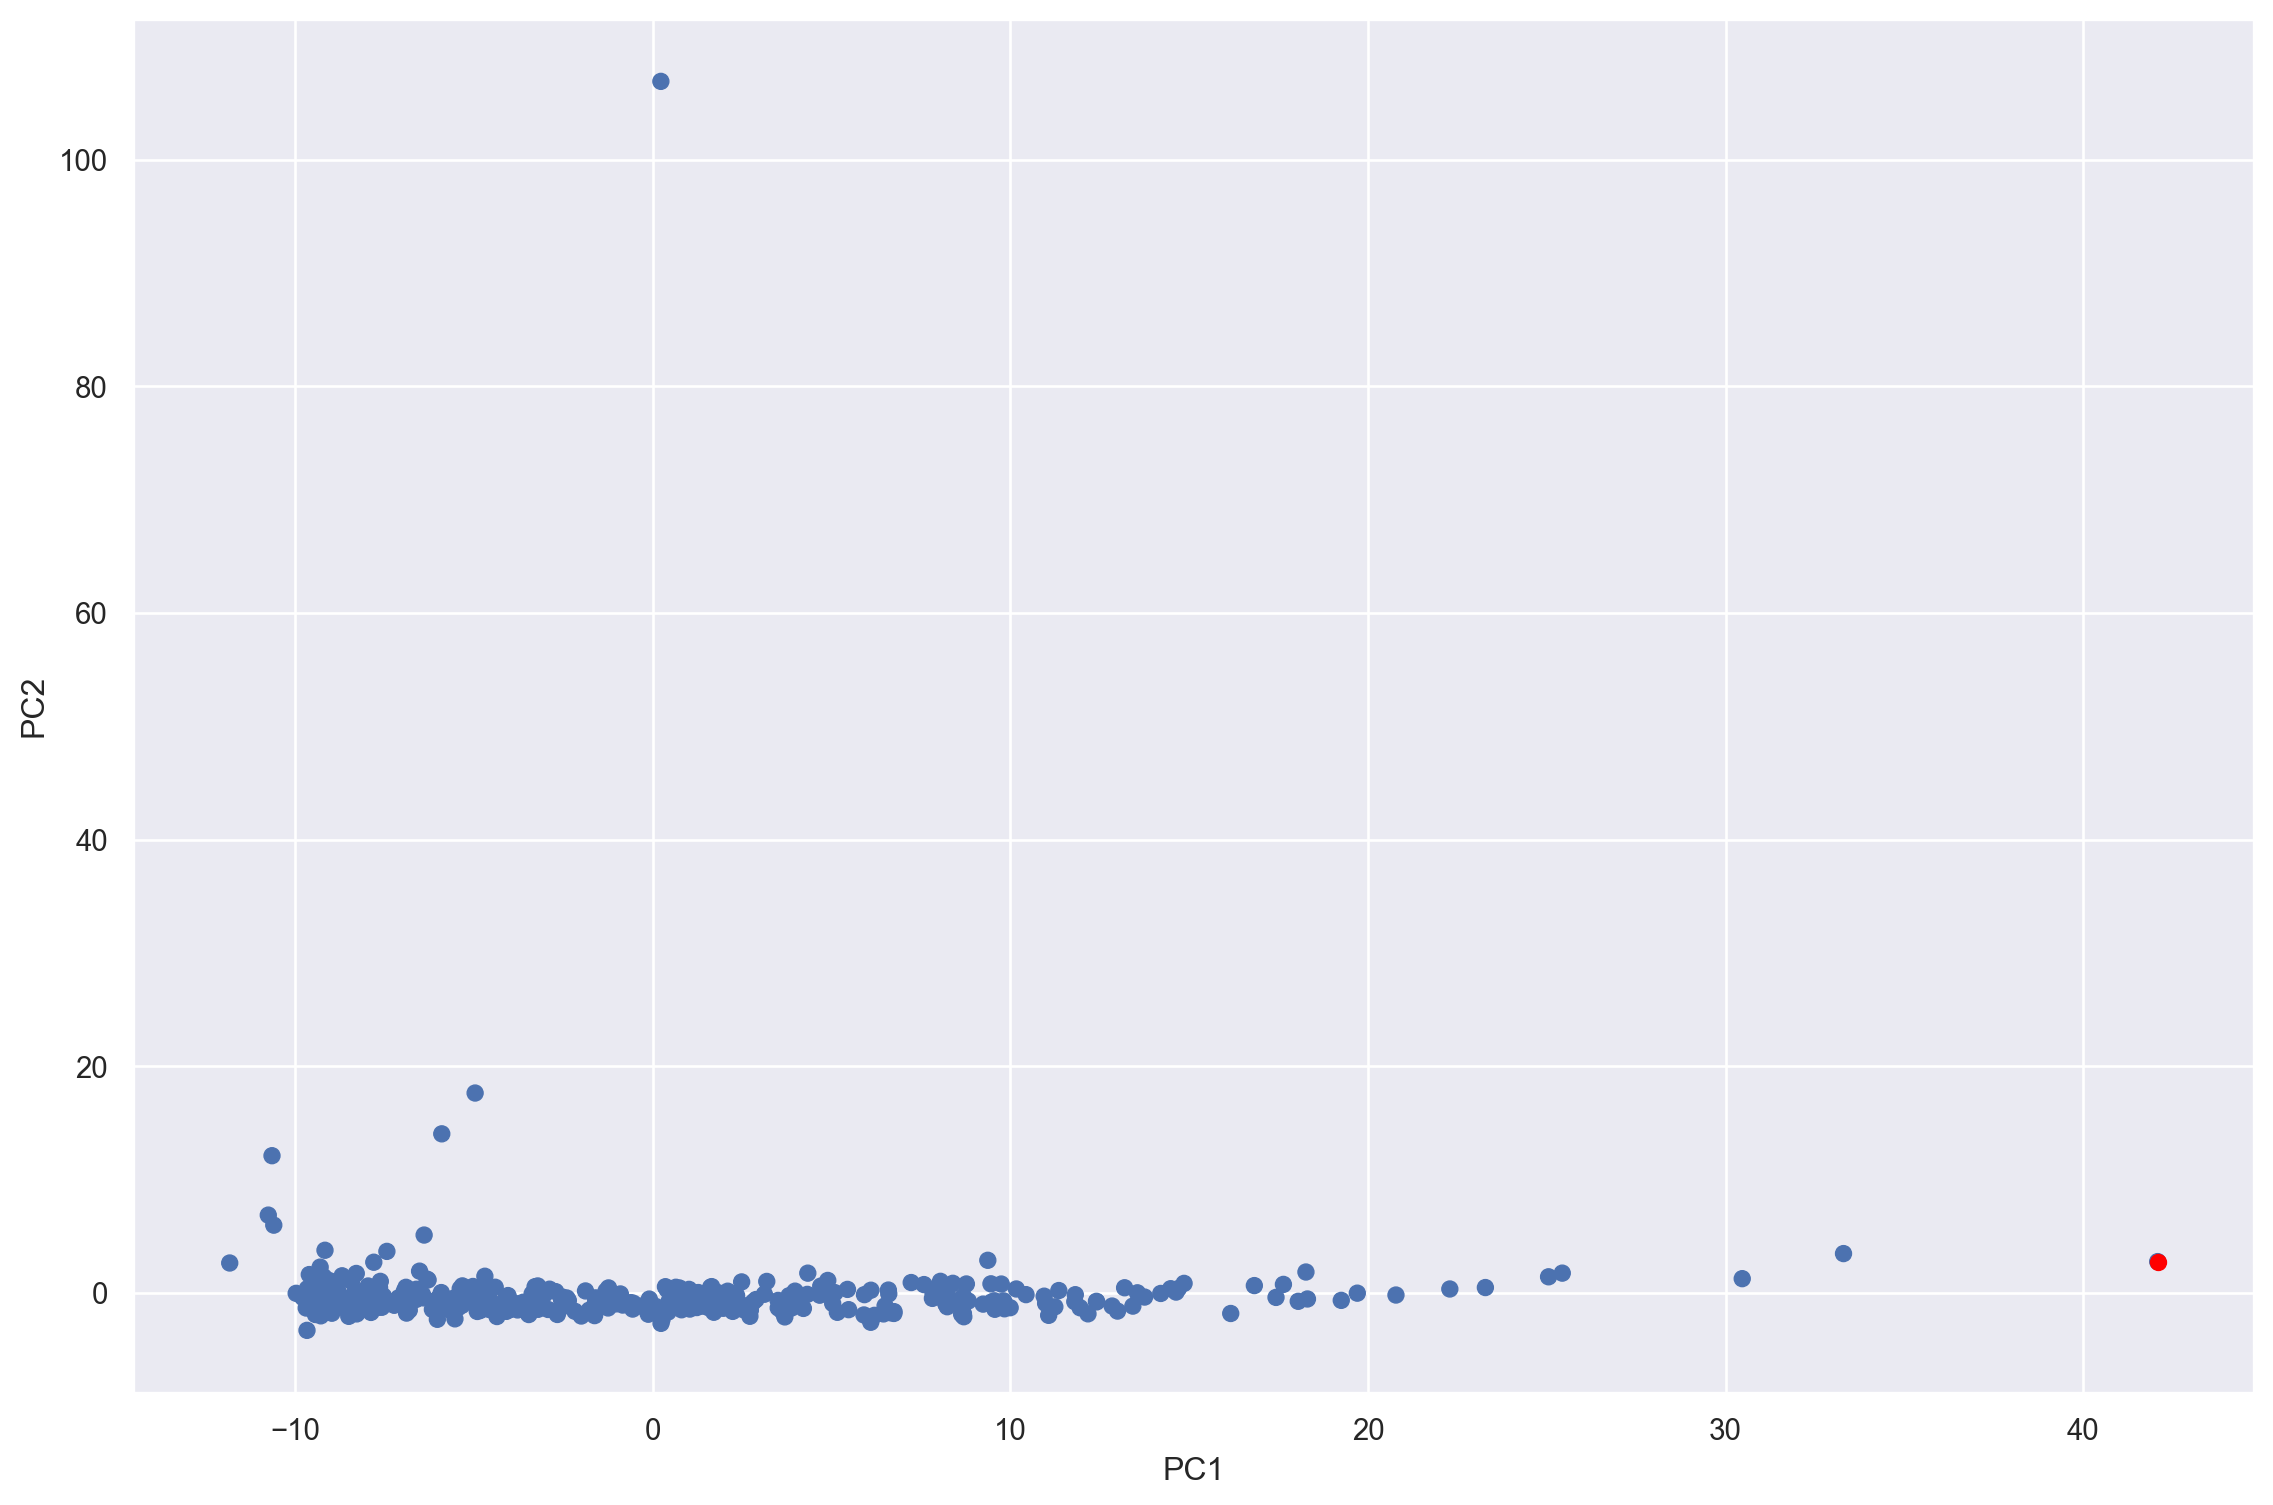

In [91]:
(
    so.Plot(pca_messi,x = "PC1", y = "PC2")
    .add(so.Dot())
    .add(so.Dot(color = "red"), data = pca_messi.iloc[[38]], x="PC1",y="PC2")
    .layout(size=(12,8))
)

In [92]:
# Veamos quien es el jugador más cercano al pinguino messi :)
K = 1
ind = 38
neighbors = NearestNeighbors(n_neighbors=K+1)  # Esta función nos devuelve los más cercanos incluyendo a si mismo, por eso tomamos k+1.
neighbors.fit(pca_messi)  # En el ajuste solamente almacenamos los datos

# Ahora podemos buscar los vecinos más cercanos a un punto cualquiera o un conjunto de puntos.
# Tenemos que pasarle un DataFrame
distances, indices = neighbors.kneighbors(pca_messi.iloc[[ind]])

In [93]:
indices.flatten()

array([ 38, 232], dtype=int64)

In [94]:
nombres_index.iloc[[232]]

player
232  Emi Buendí­a

Al finalizar nuestro modelo le recomendamos al FC Barcelona comprar al argentino Emiliano Buendía.

### Apartado (b) ~ Modelo para predecir valor de jugador.

Para realizar el apartado (b) del ejercicio vamos a realizar un modelo de regresión ridge.

In [95]:
pasar = False
pred_valor = pd.DataFrame()
for nombre in data.columns: # Me armo un nuevo dataframe en el que saco las columnas anteriores a "games" menos la edad del jugador
    if nombre=="games":
        pasar = True
    if pasar or nombre == "age":
        pred_valor[nombre] = data[[nombre]]

C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\4184363294.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred_valor[nombre] = data[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\4184363294.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred_valor[nombre] = data[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\4184363294.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [96]:
pred_valor = pred_valor.select_dtypes(exclude=["object"]) # Eliminamos las columnas de tipo object
pred_valor = pred_valor.drop(columns="CLBestScorer") # Eliminamos "CLBestScorer"

In [97]:
X_train,X_test,y_train,y_test = train_test_split(pred_valor,data[["value"]], test_size=0.2,random_state=24) #Empezamos con el modelo de Regresión

In [139]:
alpha = {"alpha": np.logspace(-5,5,100)}

In [99]:
gs = GridSearchCV(
    Ridge(fit_intercept=True),
    alpha,
    cv=5,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)

In [140]:
scaler = StandardScaler() # Escalo los datos debido a que Ridge es sensible a las escalas
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train) 
y_test = scaler.transform(y_test)

In [141]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.20450354e-03, 1.45082878e-03, 1.74752840e-03,
       2.10490414e-03, 2.53536449e-03, 3.05385551e-03, 3.67837977e-03,
       4.43062146e-03, 5.33669923e-03, 6.42807312e-03, 7.74263683e-03,
       9.32603347e-03, 1.12332403e-02, 1.35304777e-02, 1.62975083e-02,
       1.96304065e-02, 2.36448941e-02, 2.84803587e-02, 3....
       2.91505306e+03, 3.51119173e+03, 4.22924287e+03, 5.09413801e+03,
       6.13590727e+03, 7.39072203e+03, 8.90215085e+03, 1.07226722e+04,
       1.29154967e+04, 1.55567614e+04, 1.87381742e+04, 2.25701972e+04,
       2.71858824e+04, 3.27454916e+04, 3.94420606e+04, 4.75081016e+04,
       5.72236766e+04, 6.89261210e+04, 8.30217568e+04, 1.00000000e+05])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [142]:
cv_results = pd.DataFrame(gs.cv_results_)[["param_alpha", "mean_test_score", "mean_train_score"]]
cv_results[["mean_test_score", "mean_train_score",]] *= -1

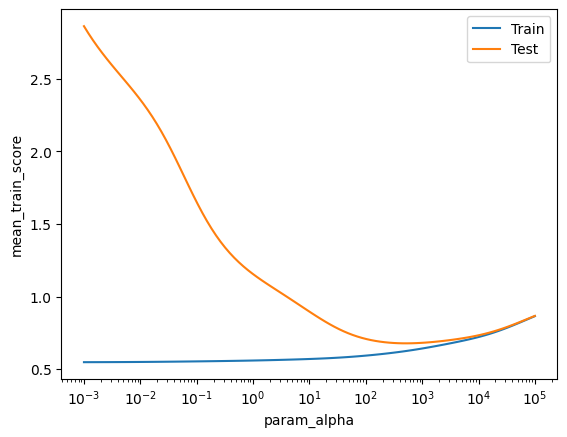

In [143]:
sns.lineplot(x="param_alpha",y="mean_train_score", data=cv_results,label="Train")
sns.lineplot(x="param_alpha",y="mean_test_score", data=cv_results,label="Test")
plt.xscale("log")
plt.show()

In [104]:
y_pred = gs.predict(X_test)

In [105]:
alpha1 = gs.best_params_["alpha"]
print(f"Nos quedamos con α = {alpha1}")

Nos quedamos con α = 546.2277217684348


In [106]:
r2_1 = r2_score(y_test, y_pred)
recm_1 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El R2 score obotenido es de: {r2_1}")
print(f"La raiz del error cuadratico medio es de: {recm_1}")

El R2 score obotenido es de: 0.5658417717100808
La raiz del error cuadratico medio es de: 0.6538001600072233


mmmmm no nos gustaron los resultados pero vamos a continuar a ver que pasa.

### Apartado (c)

In [107]:
jugador_valoracion = data[data["value"]>100000]
pasar = False
X_prediccion = pd.DataFrame()
for nombre in pred_valor.columns: # Me armo un nuevo dataframe en el que saco las columnas anteriores a "games" menos la edad del jugador
    X_prediccion[nombre] = jugador_valoracion[[nombre]]

C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\2643032639.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_prediccion[nombre] = jugador_valoracion[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\2643032639.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_prediccion[nombre] = jugador_valoracion[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\2643032639.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [108]:
X_prediccion = StandardScaler().set_output(transform="pandas").fit_transform(X_prediccion)
y_prediccion = gs.predict(X_prediccion)

C:\Users\juamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [109]:
y_real = jugador_valoracion[["value"]]
y_real = StandardScaler().set_output(transform="pandas").fit_transform(y_real)
y_real.to_numpy()

array([[-0.47364617],
       [-0.47364617],
       [-0.47364617],
       ...,
       [ 0.8713367 ],
       [-0.34555256],
       [-0.15341215]])

In [110]:
g = (y_real-y_prediccion)
g[g["value"]== g["value"].max()] # Calculamos el jugador más sobrevalorado segun el modelo 

value
1858  7.194061

In [111]:
data.iloc[1858]

Column1                  1602
player          Kylian Mbappé
nationality            fr FRA
position                   FW
squad               Paris S-G
                    ...      
Attendance              47517
CL                          1
WinCL                       0
CLBestScorer              0.0
Season                201920#
Name: 1858, Length: 400, dtype: object

In [112]:
g = (y_real-y_prediccion)
g[g["value"]== g["value"].min()] # Calculamos el jugador más infravalorado segun el modelo 

value
1429 -2.473438

In [113]:
data.iloc[1429]

Column1                    2316
player              David Silva
nationality              es ESP
position                     MF
squad           Manchester City
                     ...       
Attendance                37097
CL                            1
WinCL                         0
CLBestScorer                0.0
Season                  201920#
Name: 1429, Length: 400, dtype: object

A pesar de que los resultados del modelo no fueron tan buenos como los esperabamos. Obteniendo:  
* α = 546.2277217684348
* El R2 score obotenido de: 0.5658417717100808
* La raiz del error cuadratico medio de: 0.6538001600072233

  
Todos los modelos probados llegaban al mismo resultado siendo Kylian Mbappé el jugador más sobrevalorado y el más infravalorado es David Silva.  
Si mal no recordamos en clase dijeron que no habia problema con la eficiencia del modelo si es que daba de resultado a Mbappé como jugador sobrevalorado...  


### Apartado (d) ~ Reemplazo de Mbappé

Para realizar el ultimo apratado del ejercicio decidimos hacer lo mismo que hicimos con messi en la parte (a).

In [114]:
data[data["player"]=="Kylian Mbappé"]

Column1         player nationality position      squad  age  birth_year  \
1858     1602  Kylian Mbappé      fr FRA       FW  Paris S-G   20        1998   

          value  height              position2  ... Pts/G    xG   xGA  xGDiff  \
1858  180000000     178  Forward - Left Winger  ...  2.52  70.9  22.7    48.2   

      xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
1858       1.78       47517   1      0           0.0  201920#  

[1 rows x 400 columns]

In [115]:
data_filtro = data[data['position'].str.startswith('FW')]

In [116]:
data_filtro = data_filtro[((data_filtro["value"]<180000000) & (data_filtro["age"]<=25) & (data_filtro["squad"]!="Paris S-G")) | (data_filtro["player"]=="Kylian Mbappé")] #Queremos jugadores con un valor menor al de Messi
data_filtro = data_filtro.reset_index(drop=True) #Reseteamos los indices para hacer PCA.
data_filtro[data_filtro["player"]=="Kylian Mbappé"] #Aprovechamos y nos fijamos el indice de Messi para despues.

Column1         player nationality position      squad  age  birth_year  \
248     1602  Kylian Mbappé      fr FRA       FW  Paris S-G   20        1998   

         value  height              position2  ... Pts/G    xG   xGA  xGDiff  \
248  180000000     178  Forward - Left Winger  ...  2.52  70.9  22.7    48.2   

     xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
248       1.78       47517   1      0           0.0  201920#  

[1 rows x 400 columns]

In [117]:
pasar = False
reemplazo_mbappe = pd.DataFrame()
for nombre in data_filtro.columns: # Me armo un nuevo dataframe en el que saco las columnas anteriores a "games"
    if nombre=="games":
        pasar = True
    if pasar:
        reemplazo_mbappe[nombre] = data_filtro[[nombre]]

C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\4199782209.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reemplazo_mbappe[nombre] = data_filtro[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\4199782209.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reemplazo_mbappe[nombre] = data_filtro[[nombre]]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\4199782209.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [118]:
nombres_index = pd.DataFrame(data_filtro["player"]) # Nos armamos un dataFrame con los nombres en relacion a los indices.
nombres_index[nombres_index["player"]=="Kylian Mbappé"]

player
248  Kylian Mbappé

In [119]:
reemplazo_mbappe.info() #Vamos a quitar las columnas de tipo object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Columns: 388 entries, games to Season
dtypes: float64(239), int64(147), object(2)
memory usage: 1.1+ MB


In [120]:
reemplazo_mbappe.isna().sum() #Creemos que la unica columna con datos nulos es "CLBestScorer" asi que la vamos a quitar

games            0
games_starts     0
minutes          0
goals            0
assists          0
                ..
Attendance       0
CL               0
WinCL            0
CLBestScorer    47
Season           0
Length: 388, dtype: int64

In [121]:
reemplazo_mbappe =reemplazo_mbappe.drop(columns="CLBestScorer") # Eliminamos "CLBestScorer"

In [122]:
reemplazo_mbappe = reemplazo_mbappe.select_dtypes(exclude=["object"]) # Eliminamos las columnas de tipo object

In [123]:
X_star=StandardScaler().set_output(transform="pandas").fit_transform(reemplazo_mbappe) #Escalamos los datos

In [124]:
pca = PCA(n_components=2) # Comenzamos con PCA
principalComponents = pca.fit_transform(X_star)
pca_mbappe = pd.DataFrame(principalComponents,columns=["PC1","PC2"])

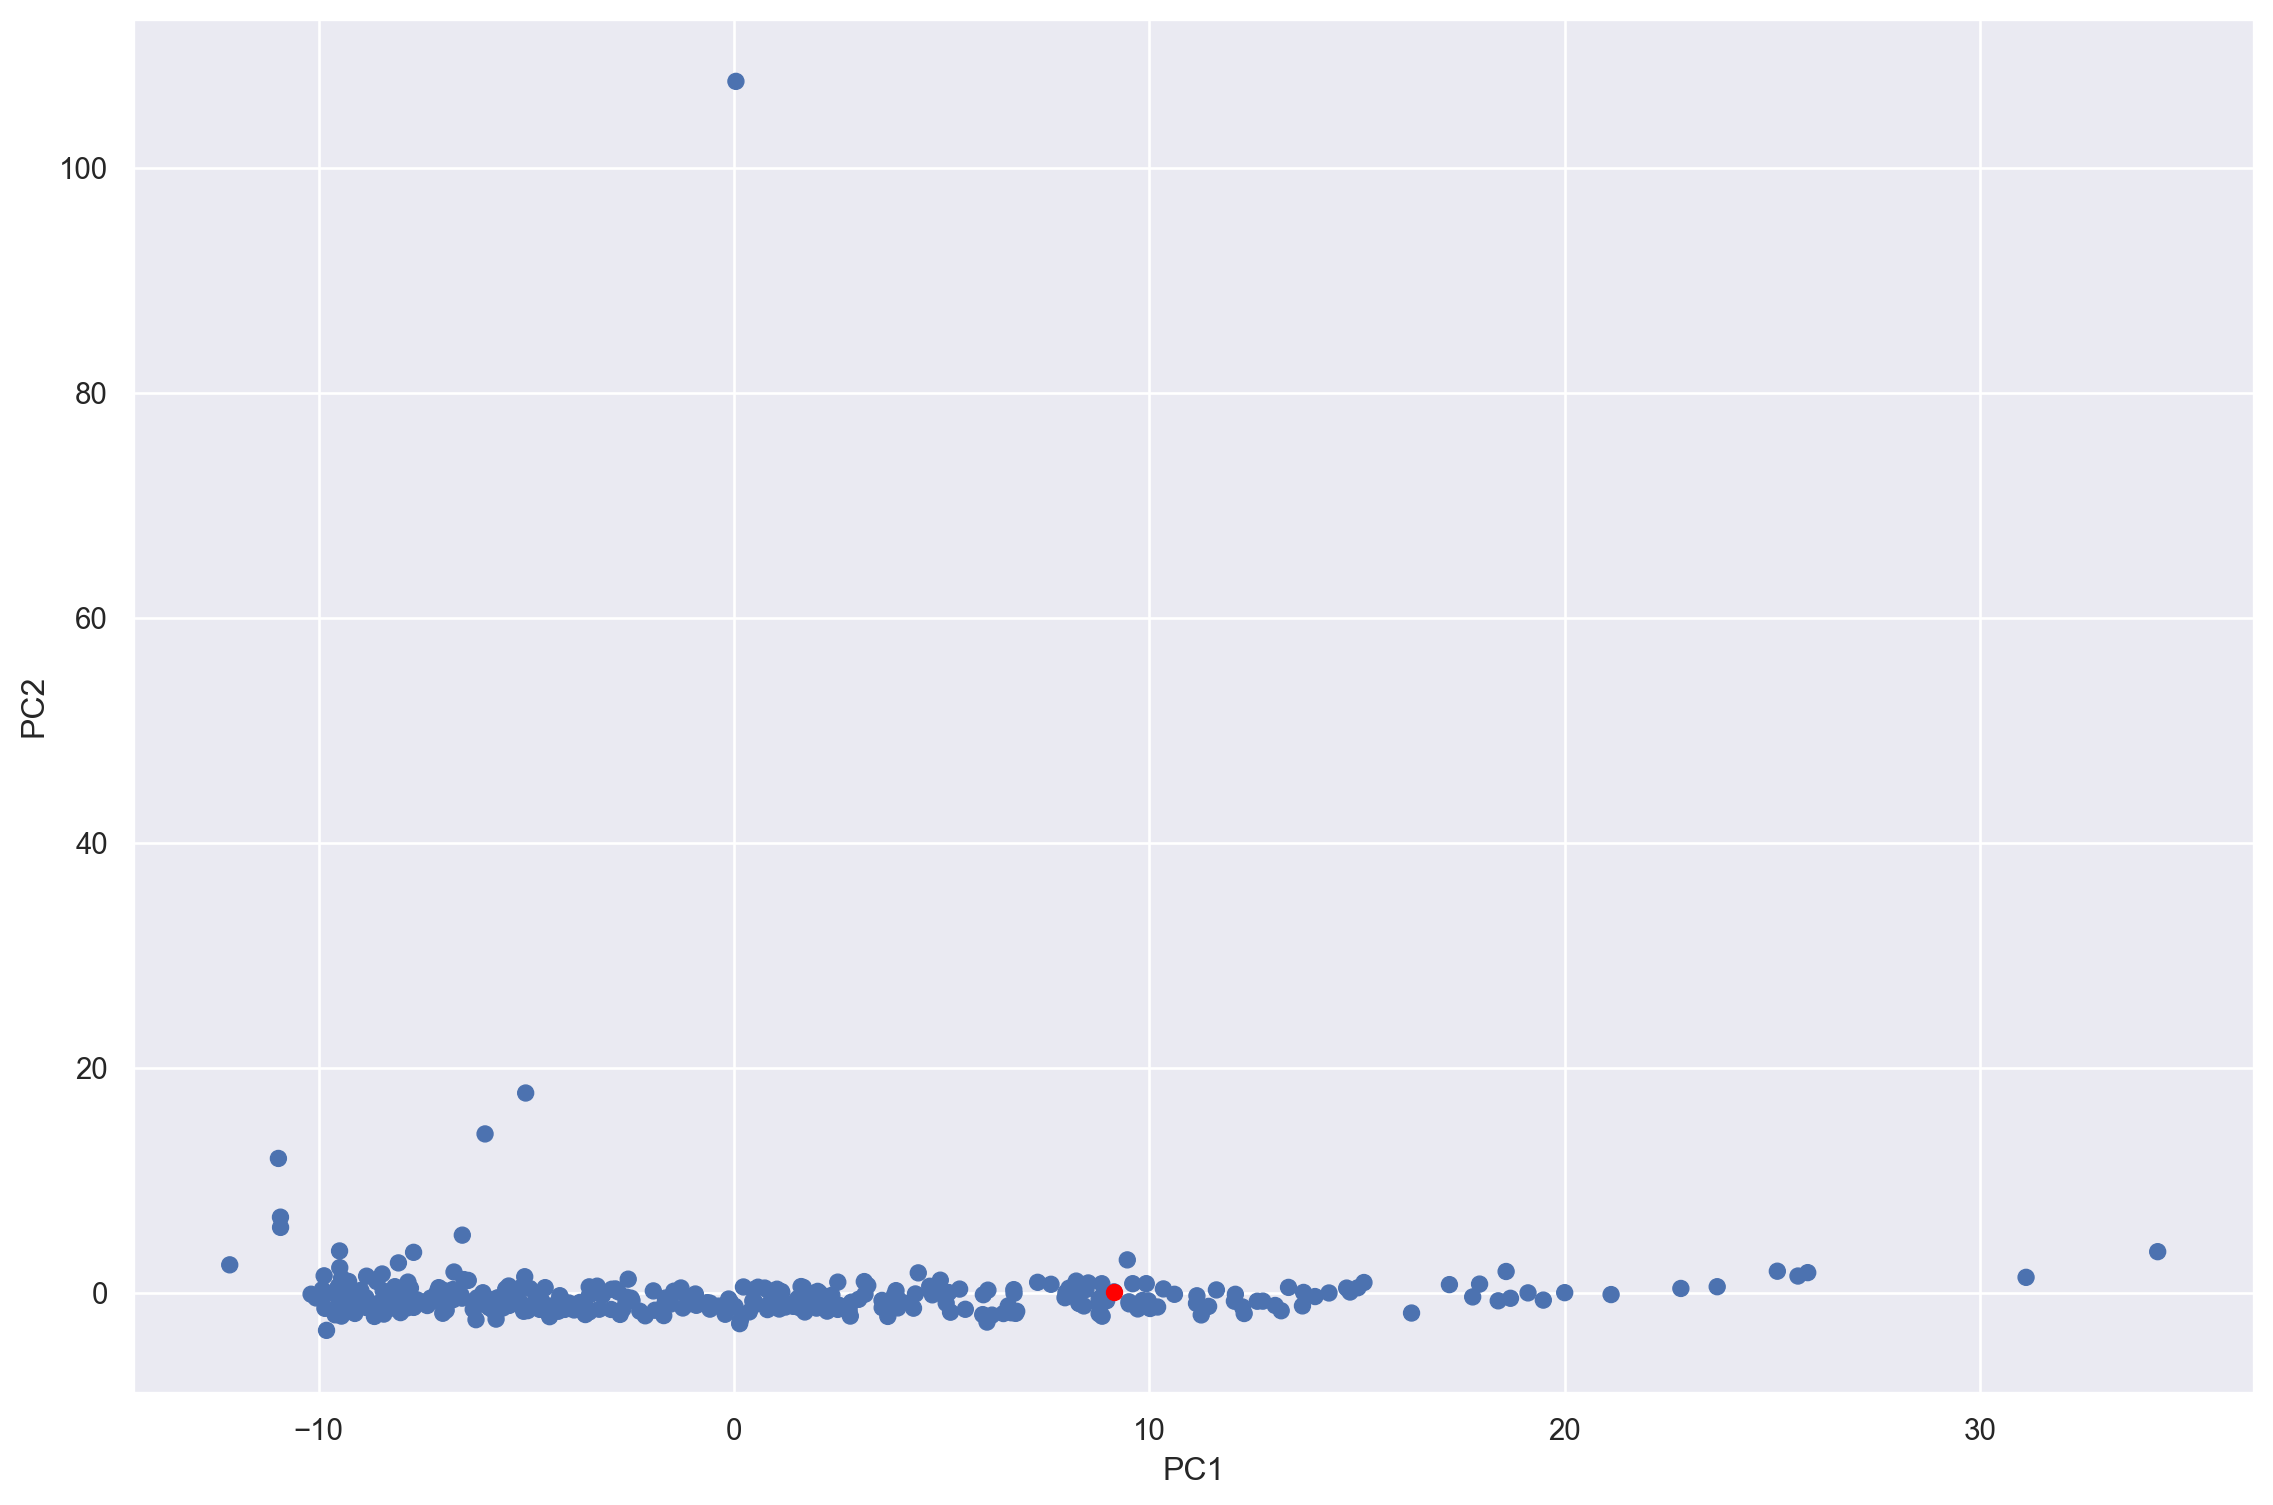

In [125]:

(
    so.Plot(pca_mbappe,x = "PC1", y = "PC2")
    .add(so.Dot())
    .add(so.Dot(color = "red"), data = pca_mbappe.iloc[[248]], x="PC1",y="PC2")
    .layout(size=(12,8))
)


In [126]:
 # Veamos quien es el jugador más cercano al Mbappé 
K = 10
ind = 248
neighbors = NearestNeighbors(n_neighbors=K+1)  # Esta función nos devuelve los más cercanos incluyendo a si mismo, por eso tomamos k+1.
neighbors.fit(pca_mbappe)  # En el ajuste solamente almacenamos los datos

# Ahora podemos buscar los vecinos más cercanos a un punto cualquiera o un conjunto de puntos.
# Tenemos que pasarle un DataFrame
distances, indices = neighbors.kneighbors(pca_mbappe.iloc[[ind]])

In [127]:
indices.flatten()

array([248, 270, 219, 124,  47, 341,  41, 158, 177, 165, 134], dtype=int64)

In [128]:
jugadores_nombre = np.array([])
for x in indices.flatten():
    if x != 248:
        jugadores_nombre = np.concatenate((jugadores_nombre,nombres_index.iloc[x].values))
jugadores_nombre

array(['Moussa Doumbia', 'Ludovic Blas', 'Valerio Verre', 'Musa Barrow',
       'Ismaila Sarr', 'Kingsley Coman', 'Moussa Diaby', 'Gabriel Jesus',
       'Maxwel Cornet', 'Ihlas Bebou'], dtype=object)

In [129]:
jugadores = nombres_index[nombres_index["player"].isin(jugadores_nombre)]
jugadores

player
20      Musa Barrow
41   Kingsley Coman
47      Musa Barrow
124   Valerio Verre
134     Ihlas Bebou
158    Moussa Diaby
165   Maxwel Cornet
177   Gabriel Jesus
219    Ludovic Blas
270  Moussa Doumbia
341    Ismaila Sarr

In [130]:
data[data["player"]=="Musa Barrow"] # viendo los datos del jugador repetido creemos que es el mismo pero que se cambio de club esa temporada

Column1       player nationality position     squad  age  birth_year  \
135      206  Musa Barrow      gm GAM    FW,MF  Atalanta   20        1998   
325      205  Musa Barrow      gm GAM       FW   Bologna   20        1998   

        value  height                 position2  ... Pts/G    xG   xGA  \
135  11000000     184  Forward - Centre-Forward  ...  2.05  81.9  41.4   
325  11000000     184  Forward - Centre-Forward  ...  1.24  53.1  54.6   

     xGDiff  xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
135    40.4       1.06       11167   1      0           0.0  201920#  
325    -1.5      -0.04       15774   0      0           0.0  201920#  

[2 rows x 400 columns]

Nuestro modelo le recomendaria al culb comprar uno de los jugadores del DataFrame anterior. Ahora vamos a ver cual es el más infravalorado segun nuestro modelo del ejercicio anterior.

In [131]:
valor_pred = data_filtro.loc[indices.flatten()]
valor_pred = valor_pred[valor_pred["player"]!="Kylian Mbappé"] # sacamos a Mbappé del DataFrame

In [132]:
valor_real = valor_pred[["value"]] # Me guardo los valores reales de mercado reales
valor_real = StandardScaler().set_output(transform="pandas").fit_transform(valor_real)

In [133]:
pred = pd.DataFrame() #Armo mi dataframe de pred con la cual voy a predecir el valor de los jugadores 
pasar=False
for x in valor_pred.columns:
    if x=="games":
        pasar=True
    if pasar or x=="age":
        pred[x]=valor_pred[x]

C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\898569401.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred[x]=valor_pred[x]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\898569401.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred[x]=valor_pred[x]
C:\Users\juamp\AppData\Local\Temp\ipykernel_9776\898569401.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [134]:
pred = pred.select_dtypes(exclude=["object"]) # eliminamos todas las columnas de tipo objeto
pred = pred.drop(columns="CLBestScorer") # Eliminamos "CLBestScorer"
pred = StandardScaler().set_output(transform="pandas").fit_transform(pred)
value_pred = gs.predict(pred)

C:\Users\juamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [135]:
value_pred

array([[-0.61839183],
       [-0.09789214],
       [-0.71913133],
       [-0.56206147],
       [-0.38549625],
       [ 1.28632592],
       [ 0.69053785],
       [ 1.674218  ],
       [-0.96919287],
       [-0.29891587]])

In [136]:
g = (valor_real-value_pred)
g[g["value"]== g["value"].min()]

value
219 -0.539951

In [137]:
data_filtro.iloc[[219]]

Column1        player nationality position   squad  age  birth_year  \
219      305  Ludovic Blas      fr FRA    FW,MF  Nantes   21        1997   

       value  height                        position2  ... Pts/G    xG   xGA  \
219  8000000     180  Midfielder - Attacking Midfield  ...  1.32  27.8  33.5   

     xGDiff  xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
219    -5.7       -0.2       24635   0      0           0.0  201920#  

[1 rows x 400 columns]

Segun nuestro modelo el jugador más infravalorado y con estadisticas parecidas a Mbappé es Ludovic Blas. Por lo que le rcomendariamos al club comprar a dicho jugaor.

In [138]:
data_filtro[data_filtro["player"]=="Kylian Mbappé"]

Column1         player nationality position      squad  age  birth_year  \
248     1602  Kylian Mbappé      fr FRA       FW  Paris S-G   20        1998   

         value  height              position2  ... Pts/G    xG   xGA  xGDiff  \
248  180000000     178  Forward - Left Winger  ...  2.52  70.9  22.7    48.2   

     xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
248       1.78       47517   1      0           0.0  201920#  

[1 rows x 400 columns]

Viendo que el jugador vale 172 Millones menos que Mbappé y tiene estadisticas similares consideramos que fue una gran recomendación al club. Ademas que tomamos en cuenta de que sea un jugador joven para que pueda tener un mejor desempeño en la alta competencia. 